# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.519966912536354 -3.022195310459988
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [19]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [20]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [21]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [42]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                    labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                      shape=[-1, 1])))
    g_lossP = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = g_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, g_lossQ, g_lossP

In [43]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [44]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.g_lossP = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [45]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(10, 4) actions:(10,)
action size:1


In [46]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [47]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [48]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [49]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/500 # success is 400 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_lossQ, g_lossP, g_loss, d_loss, _, _ = sess.run([model.g_lossQ, model.g_lossP, 
                                                           model.g_loss, model.d_loss, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'glossQ:{:.4f}'.format(g_lossQ),
              'glossP:{:.4f}'.format(g_lossP),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:112.0000 glossQ:0.6914 glossP:-0.0598 gloss:0.6914 dloss:0.6708
Episode:1 meanR:72.5000 glossQ:0.6930 glossP:-0.0247 gloss:0.6930 dloss:0.6777
Episode:2 meanR:76.0000 glossQ:0.6929 glossP:-0.0311 gloss:0.6929 dloss:0.6783
Episode:3 meanR:62.7500 glossQ:0.6917 glossP:-0.0716 gloss:0.6917 dloss:0.6472
Episode:4 meanR:57.0000 glossQ:0.6913 glossP:-0.0850 gloss:0.6913 dloss:0.6415
Episode:5 meanR:56.8333 glossQ:0.6910 glossP:-0.0899 gloss:0.6910 dloss:0.6443
Episode:6 meanR:53.4286 glossQ:0.6891 glossP:-0.1215 gloss:0.6891 dloss:0.6198
Episode:7 meanR:52.2500 glossQ:0.6868 glossP:-0.1497 gloss:0.6868 dloss:0.6082
Episode:8 meanR:51.6667 glossQ:0.6858 glossP:-0.1625 gloss:0.6858 dloss:0.6028
Episode:9 meanR:51.1000 glossQ:0.6825 glossP:-0.1932 gloss:0.6825 dloss:0.5864
Episode:10 meanR:55.0909 glossQ:0.6855 glossP:-0.1704 gloss:0.6855 dloss:0.6233
Episode:11 meanR:52.5833 glossQ:0.6808 glossP:-0.2214 gloss:0.6808 dloss:0.5625
Episode:12 meanR:53.9231 glossQ:0.6764 glossP:-0.

Episode:109 meanR:12.7300 glossQ:0.0638 glossP:-0.0006 gloss:0.0638 dloss:0.0977
Episode:110 meanR:11.8700 glossQ:0.0722 glossP:-0.0004 gloss:0.0722 dloss:0.0965
Episode:111 meanR:11.7200 glossQ:0.0907 glossP:-0.0003 gloss:0.0907 dloss:0.1046
Episode:112 meanR:11.1200 glossQ:0.1301 glossP:-0.0002 gloss:0.1301 dloss:0.1054
Episode:113 meanR:10.9800 glossQ:0.1400 glossP:-0.0002 gloss:0.1400 dloss:0.0992
Episode:114 meanR:10.3000 glossQ:0.0819 glossP:-0.0001 gloss:0.0819 dloss:0.1144
Episode:115 meanR:10.2000 glossQ:0.0759 glossP:-0.0001 gloss:0.0759 dloss:0.0956
Episode:116 meanR:10.0700 glossQ:0.0850 glossP:-0.0001 gloss:0.0850 dloss:0.0865
Episode:117 meanR:9.8200 glossQ:0.0773 glossP:-0.0001 gloss:0.0773 dloss:0.0959
Episode:118 meanR:9.7800 glossQ:0.0875 glossP:-0.0000 gloss:0.0875 dloss:0.0865
Episode:119 meanR:9.8000 glossQ:0.0756 glossP:-0.0000 gloss:0.0756 dloss:0.1046
Episode:120 meanR:9.7300 glossQ:0.1016 glossP:-0.0000 gloss:0.1016 dloss:0.1034
Episode:121 meanR:9.7000 glossQ:

Episode:229 meanR:9.1800 glossQ:0.1459 glossP:0.0000 gloss:0.1459 dloss:0.1068
Episode:230 meanR:9.2000 glossQ:0.1130 glossP:0.0000 gloss:0.1130 dloss:0.1042
Episode:231 meanR:9.2000 glossQ:0.0710 glossP:0.0000 gloss:0.0710 dloss:0.0965
Episode:232 meanR:9.2100 glossQ:0.0624 glossP:0.0000 gloss:0.0624 dloss:0.1078
Episode:233 meanR:9.2100 glossQ:0.0992 glossP:0.0000 gloss:0.0992 dloss:0.1037
Episode:234 meanR:9.2000 glossQ:0.1734 glossP:0.0000 gloss:0.1734 dloss:0.1042
Episode:235 meanR:9.2000 glossQ:0.0574 glossP:0.0000 gloss:0.0574 dloss:0.1103
Episode:236 meanR:9.2000 glossQ:0.0491 glossP:0.0000 gloss:0.0491 dloss:0.1020
Episode:237 meanR:9.2100 glossQ:0.0670 glossP:0.0000 gloss:0.0670 dloss:0.0983
Episode:238 meanR:9.2000 glossQ:0.1070 glossP:0.0000 gloss:0.1070 dloss:0.0964
Episode:239 meanR:9.2100 glossQ:0.1416 glossP:0.0000 gloss:0.1416 dloss:0.0997
Episode:240 meanR:9.2000 glossQ:0.0800 glossP:0.0000 gloss:0.0800 dloss:0.0876
Episode:241 meanR:9.2200 glossQ:0.0393 glossP:0.0000

Episode:334 meanR:14.0800 glossQ:0.0770 glossP:-0.1400 gloss:0.0770 dloss:0.1212
Episode:335 meanR:14.0600 glossQ:0.0763 glossP:-0.1299 gloss:0.0763 dloss:0.1037
Episode:336 meanR:14.0700 glossQ:0.0578 glossP:-0.0869 gloss:0.0578 dloss:0.1431
Episode:337 meanR:14.0700 glossQ:0.0605 glossP:-0.0871 gloss:0.0605 dloss:0.1221
Episode:338 meanR:14.0600 glossQ:0.0635 glossP:-0.0880 gloss:0.0635 dloss:0.1036
Episode:339 meanR:14.0700 glossQ:0.0507 glossP:-0.0626 gloss:0.0507 dloss:0.1395
Episode:340 meanR:14.0900 glossQ:0.0442 glossP:-0.0540 gloss:0.0442 dloss:0.1441
Episode:341 meanR:14.0900 glossQ:0.0431 glossP:-0.0494 gloss:0.0431 dloss:0.1400
Episode:342 meanR:14.1000 glossQ:0.0464 glossP:-0.0506 gloss:0.0464 dloss:0.1177
Episode:343 meanR:14.0900 glossQ:0.0465 glossP:-0.0487 gloss:0.0465 dloss:0.1167
Episode:344 meanR:14.0900 glossQ:0.0411 glossP:-0.0399 gloss:0.0411 dloss:0.1336
Episode:345 meanR:14.0800 glossQ:0.0461 glossP:-0.0434 gloss:0.0461 dloss:0.1112
Episode:346 meanR:14.0700 gl

Episode:437 meanR:9.3500 glossQ:0.1179 glossP:-0.0465 gloss:0.1179 dloss:0.1000
Episode:438 meanR:9.3600 glossQ:0.0981 glossP:-0.0289 gloss:0.0981 dloss:0.0917
Episode:439 meanR:9.3500 glossQ:0.0822 glossP:-0.0432 gloss:0.0822 dloss:0.0924
Episode:440 meanR:9.3400 glossQ:0.0732 glossP:-0.0399 gloss:0.0732 dloss:0.0934
Episode:441 meanR:9.3400 glossQ:0.0686 glossP:-0.0380 gloss:0.0686 dloss:0.1040
Episode:442 meanR:9.3500 glossQ:0.0767 glossP:-0.0406 gloss:0.0767 dloss:0.1024
Episode:443 meanR:9.3600 glossQ:0.0951 glossP:-0.0387 gloss:0.0951 dloss:0.1002
Episode:444 meanR:9.3600 glossQ:0.1229 glossP:-0.0311 gloss:0.1229 dloss:0.1001
Episode:445 meanR:9.3600 glossQ:0.1516 glossP:-0.0330 gloss:0.1516 dloss:0.0955
Episode:446 meanR:9.3500 glossQ:0.1369 glossP:-0.0461 gloss:0.1369 dloss:0.0938
Episode:447 meanR:9.3500 glossQ:0.1014 glossP:-0.0339 gloss:0.1014 dloss:0.0999
Episode:448 meanR:9.3600 glossQ:0.0828 glossP:-0.0362 gloss:0.0828 dloss:0.1013
Episode:449 meanR:9.3700 glossQ:0.0806 g

Episode:552 meanR:10.3800 glossQ:0.2352 glossP:-1.5296 gloss:0.2352 dloss:0.2439
Episode:553 meanR:10.6200 glossQ:0.3685 glossP:-1.0954 gloss:0.3685 dloss:0.2638
Episode:554 meanR:10.8200 glossQ:0.4523 glossP:-0.8817 gloss:0.4523 dloss:0.2764
Episode:555 meanR:10.9900 glossQ:0.3862 glossP:-1.0316 gloss:0.3862 dloss:0.2343
Episode:556 meanR:11.1200 glossQ:0.2529 glossP:-1.4117 gloss:0.2529 dloss:0.1920
Episode:557 meanR:11.2500 glossQ:0.1496 glossP:-1.8151 gloss:0.1496 dloss:0.1762
Episode:558 meanR:11.4300 glossQ:0.0871 glossP:-2.1878 gloss:0.0871 dloss:0.2548
Episode:559 meanR:11.6200 glossQ:0.0677 glossP:-2.3551 gloss:0.0677 dloss:0.2603
Episode:560 meanR:11.7800 glossQ:0.0667 glossP:-2.3573 gloss:0.0667 dloss:0.2342
Episode:561 meanR:11.9300 glossQ:0.0769 glossP:-2.2638 gloss:0.0769 dloss:0.2103
Episode:562 meanR:12.0900 glossQ:0.1009 glossP:-2.0663 gloss:0.1009 dloss:0.2155
Episode:563 meanR:12.2400 glossQ:0.1461 glossP:-1.8047 gloss:0.1461 dloss:0.2034
Episode:564 meanR:12.3400 gl

Episode:663 meanR:16.2600 glossQ:0.0047 glossP:-0.0050 gloss:0.0047 dloss:0.2008
Episode:664 meanR:16.1600 glossQ:0.0072 glossP:-0.0027 gloss:0.0072 dloss:0.1593
Episode:665 meanR:16.0500 glossQ:0.0111 glossP:-0.0050 gloss:0.0111 dloss:0.1643
Episode:666 meanR:15.8700 glossQ:0.0189 glossP:-0.0056 gloss:0.0189 dloss:0.1280
Episode:667 meanR:15.7500 glossQ:0.0280 glossP:-0.0053 gloss:0.0280 dloss:0.1316
Episode:668 meanR:15.6300 glossQ:0.0516 glossP:-0.0059 gloss:0.0516 dloss:0.1027
Episode:669 meanR:15.5400 glossQ:0.0875 glossP:-0.0040 gloss:0.0875 dloss:0.0956
Episode:670 meanR:15.4100 glossQ:0.1345 glossP:-0.0017 gloss:0.1345 dloss:0.1037
Episode:671 meanR:15.2200 glossQ:0.2182 glossP:-0.0028 gloss:0.2182 dloss:0.1146
Episode:672 meanR:15.1400 glossQ:0.2831 glossP:-0.0025 gloss:0.2831 dloss:0.1306
Episode:673 meanR:15.0400 glossQ:0.2817 glossP:-0.0033 gloss:0.2817 dloss:0.1303
Episode:674 meanR:14.9400 glossQ:0.2301 glossP:-0.0033 gloss:0.2301 dloss:0.1170
Episode:675 meanR:14.7600 gl

Episode:774 meanR:11.2300 glossQ:0.1856 glossP:-1.8376 gloss:0.1856 dloss:0.1994
Episode:775 meanR:11.4600 glossQ:0.1970 glossP:-1.7913 gloss:0.1970 dloss:0.2406
Episode:776 meanR:11.6400 glossQ:0.2056 glossP:-1.7494 gloss:0.2056 dloss:0.2049
Episode:777 meanR:11.7800 glossQ:0.2158 glossP:-1.7014 gloss:0.2158 dloss:0.1993
Episode:778 meanR:11.9000 glossQ:0.2251 glossP:-1.6793 gloss:0.2251 dloss:0.1777
Episode:779 meanR:12.0200 glossQ:0.2258 glossP:-1.6773 gloss:0.2258 dloss:0.1833
Episode:780 meanR:12.1600 glossQ:0.2171 glossP:-1.7029 gloss:0.2171 dloss:0.1938
Episode:781 meanR:12.3100 glossQ:0.2119 glossP:-1.7349 gloss:0.2119 dloss:0.1935
Episode:782 meanR:12.5000 glossQ:0.2028 glossP:-1.7766 gloss:0.2028 dloss:0.2166
Episode:783 meanR:12.6000 glossQ:0.1949 glossP:-1.8134 gloss:0.1949 dloss:0.1693
Episode:784 meanR:12.7500 glossQ:0.1838 glossP:-1.8644 gloss:0.1838 dloss:0.1933
Episode:785 meanR:12.9800 glossQ:0.1775 glossP:-1.8866 gloss:0.1775 dloss:0.2433
Episode:786 meanR:13.1200 gl

Episode:878 meanR:31.7400 glossQ:0.1957 glossP:-1.8729 gloss:0.1957 dloss:0.1464
Episode:879 meanR:31.7000 glossQ:0.1722 glossP:-1.9851 gloss:0.1722 dloss:0.1565
Episode:880 meanR:31.6100 glossQ:0.1549 glossP:-2.0812 gloss:0.1549 dloss:0.1365
Episode:881 meanR:31.5400 glossQ:0.1346 glossP:-2.2019 gloss:0.1346 dloss:0.1498
Episode:882 meanR:31.4500 glossQ:0.1190 glossP:-2.3061 gloss:0.1190 dloss:0.1653
Episode:883 meanR:31.3800 glossQ:0.1063 glossP:-2.3959 gloss:0.1063 dloss:0.1221
Episode:884 meanR:31.2800 glossQ:0.0992 glossP:-2.4415 gloss:0.0992 dloss:0.1301
Episode:885 meanR:31.1200 glossQ:0.0954 glossP:-2.4762 gloss:0.0954 dloss:0.1462
Episode:886 meanR:31.0600 glossQ:0.0859 glossP:-2.5569 gloss:0.0859 dloss:0.1643
Episode:887 meanR:31.0000 glossQ:0.0826 glossP:-2.5995 gloss:0.0826 dloss:0.1407
Episode:888 meanR:30.9000 glossQ:0.0833 glossP:-2.5839 gloss:0.0833 dloss:0.1405
Episode:889 meanR:30.6800 glossQ:0.0816 glossP:-2.5979 gloss:0.0816 dloss:0.1409
Episode:890 meanR:30.7600 gl

Episode:986 meanR:15.0700 glossQ:0.1963 glossP:-1.7922 gloss:0.1963 dloss:0.1577
Episode:987 meanR:15.1600 glossQ:0.1933 glossP:-1.8109 gloss:0.1933 dloss:0.1932
Episode:988 meanR:15.2700 glossQ:0.1834 glossP:-1.8529 gloss:0.1834 dloss:0.2056
Episode:989 meanR:15.2800 glossQ:0.1816 glossP:-1.8633 gloss:0.1816 dloss:0.1443
Episode:990 meanR:15.3100 glossQ:0.1776 glossP:-1.8845 gloss:0.1776 dloss:0.1687
Episode:991 meanR:15.3300 glossQ:0.1692 glossP:-1.9141 gloss:0.1692 dloss:0.1495
Episode:992 meanR:15.3900 glossQ:0.1611 glossP:-1.9438 gloss:0.1611 dloss:0.1750
Episode:993 meanR:15.4800 glossQ:0.1566 glossP:-1.9827 gloss:0.1566 dloss:0.1950
Episode:994 meanR:15.5500 glossQ:0.1606 glossP:-1.9835 gloss:0.1606 dloss:0.1816
Episode:995 meanR:15.5400 glossQ:0.1549 glossP:-1.9905 gloss:0.1549 dloss:0.1359
Episode:996 meanR:15.6300 glossQ:0.1567 glossP:-1.9935 gloss:0.1567 dloss:0.1753
Episode:997 meanR:15.7300 glossQ:0.1568 glossP:-2.0008 gloss:0.1568 dloss:0.1818
Episode:998 meanR:15.8500 gl

Episode:1094 meanR:19.4500 glossQ:0.1721 glossP:-1.9411 gloss:0.1721 dloss:0.1496
Episode:1095 meanR:19.5000 glossQ:0.1629 glossP:-1.9788 gloss:0.1629 dloss:0.1684
Episode:1096 meanR:19.4600 glossQ:0.1568 glossP:-2.0030 gloss:0.1568 dloss:0.1489
Episode:1097 meanR:19.4400 glossQ:0.1461 glossP:-2.0715 gloss:0.1461 dloss:0.1690
Episode:1098 meanR:19.3400 glossQ:0.1439 glossP:-2.1006 gloss:0.1439 dloss:0.1421
Episode:1099 meanR:19.2100 glossQ:0.1349 glossP:-2.1350 gloss:0.1349 dloss:0.1283
Episode:1100 meanR:19.1800 glossQ:0.1310 glossP:-2.1654 gloss:0.1310 dloss:0.1493
Episode:1101 meanR:19.2000 glossQ:0.1285 glossP:-2.1745 gloss:0.1285 dloss:0.1848
Episode:1102 meanR:19.1400 glossQ:0.1318 glossP:-2.1646 gloss:0.1318 dloss:0.1772
Episode:1103 meanR:19.1300 glossQ:0.1399 glossP:-2.1117 gloss:0.1399 dloss:0.1352
Episode:1104 meanR:19.1300 glossQ:0.1382 glossP:-2.1201 gloss:0.1382 dloss:0.1972
Episode:1105 meanR:19.1500 glossQ:0.1518 glossP:-2.0554 gloss:0.1518 dloss:0.1621
Episode:1106 mea

Episode:1198 meanR:18.4000 glossQ:0.1661 glossP:-1.9671 gloss:0.1661 dloss:0.1619
Episode:1199 meanR:18.4400 glossQ:0.1680 glossP:-1.9558 gloss:0.1680 dloss:0.1556
Episode:1200 meanR:18.4600 glossQ:0.1679 glossP:-1.9686 gloss:0.1679 dloss:0.1619
Episode:1201 meanR:18.4500 glossQ:0.1650 glossP:-1.9765 gloss:0.1650 dloss:0.1746
Episode:1202 meanR:18.4100 glossQ:0.1632 glossP:-1.9936 gloss:0.1632 dloss:0.1490
Episode:1203 meanR:18.4500 glossQ:0.1597 glossP:-2.0059 gloss:0.1597 dloss:0.1619
Episode:1204 meanR:18.3600 glossQ:0.1591 glossP:-2.0129 gloss:0.1591 dloss:0.1359
Episode:1205 meanR:18.3400 glossQ:0.1572 glossP:-2.0242 gloss:0.1572 dloss:0.1488
Episode:1206 meanR:18.3000 glossQ:0.1506 glossP:-2.0538 gloss:0.1506 dloss:0.1487
Episode:1207 meanR:18.2200 glossQ:0.1493 glossP:-2.0666 gloss:0.1493 dloss:0.1221
Episode:1208 meanR:18.2000 glossQ:0.1381 glossP:-2.1273 gloss:0.1381 dloss:0.1489
Episode:1209 meanR:18.1500 glossQ:0.1343 glossP:-2.1332 gloss:0.1343 dloss:0.1420
Episode:1210 mea

Episode:1309 meanR:17.2800 glossQ:0.1467 glossP:-2.0764 gloss:0.1467 dloss:0.1755
Episode:1310 meanR:17.2500 glossQ:0.1521 glossP:-2.0364 gloss:0.1521 dloss:0.1288
Episode:1311 meanR:17.3000 glossQ:0.1552 glossP:-2.0263 gloss:0.1552 dloss:0.1618
Episode:1312 meanR:17.2900 glossQ:0.1594 glossP:-2.0010 gloss:0.1594 dloss:0.1293
Episode:1313 meanR:17.2800 glossQ:0.1552 glossP:-2.0286 gloss:0.1552 dloss:0.1225
Episode:1314 meanR:17.2700 glossQ:0.1564 glossP:-2.0195 gloss:0.1564 dloss:0.1683
Episode:1315 meanR:17.2700 glossQ:0.1498 glossP:-2.0444 gloss:0.1498 dloss:0.1420
Episode:1316 meanR:17.2500 glossQ:0.1460 glossP:-2.0791 gloss:0.1460 dloss:0.1486
Episode:1317 meanR:17.2300 glossQ:0.1440 glossP:-2.0959 gloss:0.1440 dloss:0.1486
Episode:1318 meanR:17.2200 glossQ:0.1419 glossP:-2.1048 gloss:0.1419 dloss:0.1351
Episode:1319 meanR:17.2500 glossQ:0.1388 glossP:-2.1258 gloss:0.1388 dloss:0.1487
Episode:1320 meanR:17.2200 glossQ:0.1381 glossP:-2.1302 gloss:0.1381 dloss:0.1350
Episode:1321 mea

Episode:1414 meanR:17.7100 glossQ:0.1504 glossP:-2.0579 gloss:0.1504 dloss:0.1818
Episode:1415 meanR:17.7700 glossQ:0.1682 glossP:-1.9624 gloss:0.1682 dloss:0.1808
Episode:1416 meanR:17.7900 glossQ:0.1841 glossP:-1.8843 gloss:0.1841 dloss:0.1623
Episode:1417 meanR:17.8000 glossQ:0.1953 glossP:-1.8402 gloss:0.1953 dloss:0.1571
Episode:1418 meanR:17.8300 glossQ:0.2000 glossP:-1.8110 gloss:0.2000 dloss:0.1576
Episode:1419 meanR:17.8200 glossQ:0.1970 glossP:-1.8298 gloss:0.1970 dloss:0.1455
Episode:1420 meanR:17.8800 glossQ:0.1858 glossP:-1.8813 gloss:0.1858 dloss:0.1745
Episode:1421 meanR:17.8700 glossQ:0.1719 glossP:-1.9487 gloss:0.1719 dloss:0.1429
Episode:1422 meanR:17.8900 glossQ:0.1568 glossP:-2.0291 gloss:0.1568 dloss:0.1551
Episode:1423 meanR:17.9100 glossQ:0.1451 glossP:-2.0866 gloss:0.1451 dloss:0.1553
Episode:1424 meanR:17.8600 glossQ:0.1376 glossP:-2.1360 gloss:0.1376 dloss:0.1486
Episode:1425 meanR:17.8600 glossQ:0.1292 glossP:-2.1833 gloss:0.1292 dloss:0.1561
Episode:1426 mea

Episode:1526 meanR:15.1000 glossQ:0.1148 glossP:-0.8771 gloss:0.1148 dloss:0.0855
Episode:1527 meanR:15.0100 glossQ:0.1029 glossP:-0.9470 gloss:0.1029 dloss:0.1006
Episode:1528 meanR:14.9400 glossQ:0.1031 glossP:-0.9597 gloss:0.1031 dloss:0.0926
Episode:1529 meanR:14.8600 glossQ:0.0955 glossP:-0.9864 gloss:0.0955 dloss:0.1006
Episode:1530 meanR:14.8000 glossQ:0.0889 glossP:-1.0490 gloss:0.0889 dloss:0.1009
Episode:1531 meanR:14.7200 glossQ:0.0893 glossP:-1.0503 gloss:0.0893 dloss:0.1009
Episode:1532 meanR:14.6700 glossQ:0.0874 glossP:-1.0547 gloss:0.0874 dloss:0.1010
Episode:1533 meanR:14.5800 glossQ:0.0866 glossP:-1.0676 gloss:0.0866 dloss:0.1011
Episode:1534 meanR:14.4400 glossQ:0.0956 glossP:-1.0308 gloss:0.0956 dloss:0.0925
Episode:1535 meanR:14.3500 glossQ:0.1015 glossP:-0.9814 gloss:0.1015 dloss:0.0846
Episode:1536 meanR:14.2900 glossQ:0.0934 glossP:-1.0580 gloss:0.0934 dloss:0.1008
Episode:1537 meanR:14.2300 glossQ:0.0971 glossP:-1.0435 gloss:0.0971 dloss:0.0925
Episode:1538 mea

Episode:1635 meanR:9.4100 glossQ:0.0946 glossP:-0.4656 gloss:0.0946 dloss:0.1024
Episode:1636 meanR:9.4100 glossQ:0.0986 glossP:-0.4263 gloss:0.0986 dloss:0.1024
Episode:1637 meanR:9.4200 glossQ:0.1061 glossP:-0.4011 gloss:0.1061 dloss:0.1025
Episode:1638 meanR:9.4200 glossQ:0.1117 glossP:-0.3721 gloss:0.1117 dloss:0.0947
Episode:1639 meanR:9.4300 glossQ:0.0999 glossP:-0.3577 gloss:0.0999 dloss:0.1025
Episode:1640 meanR:9.4200 glossQ:0.0877 glossP:-0.3212 gloss:0.0877 dloss:0.1028
Episode:1641 meanR:9.4400 glossQ:0.0908 glossP:-0.2999 gloss:0.0908 dloss:0.1027
Episode:1642 meanR:9.4200 glossQ:0.1108 glossP:-0.2850 gloss:0.1108 dloss:0.0867
Episode:1643 meanR:9.4300 glossQ:0.0928 glossP:-0.2457 gloss:0.0928 dloss:0.0939
Episode:1644 meanR:9.4300 glossQ:0.0845 glossP:-0.2455 gloss:0.0845 dloss:0.0942
Episode:1645 meanR:9.4300 glossQ:0.0757 glossP:-0.2085 gloss:0.0757 dloss:0.1037
Episode:1646 meanR:9.4500 glossQ:0.0884 glossP:-0.1849 gloss:0.0884 dloss:0.1027
Episode:1647 meanR:9.4500 gl

Episode:1737 meanR:9.4100 glossQ:0.0618 glossP:-0.0006 gloss:0.0618 dloss:0.1047
Episode:1738 meanR:9.4200 glossQ:0.0542 glossP:-0.0009 gloss:0.0542 dloss:0.1067
Episode:1739 meanR:9.4100 glossQ:0.1274 glossP:-0.0012 gloss:0.1274 dloss:0.0946
Episode:1740 meanR:9.4100 glossQ:0.1260 glossP:-0.0009 gloss:0.1260 dloss:0.1018
Episode:1741 meanR:9.4100 glossQ:0.0785 glossP:-0.0012 gloss:0.0785 dloss:0.1021
Episode:1742 meanR:9.4200 glossQ:0.0861 glossP:-0.0019 gloss:0.0861 dloss:0.0930
Episode:1743 meanR:9.4200 glossQ:0.1046 glossP:-0.0021 gloss:0.1046 dloss:0.0931
Episode:1744 meanR:9.4200 glossQ:0.0992 glossP:-0.0020 gloss:0.0992 dloss:0.0929
Episode:1745 meanR:9.4300 glossQ:0.0775 glossP:-0.0024 gloss:0.0775 dloss:0.1113
Episode:1746 meanR:9.4200 glossQ:0.1548 glossP:-0.0027 gloss:0.1548 dloss:0.0979
Episode:1747 meanR:9.4100 glossQ:0.0667 glossP:-0.0025 gloss:0.0667 dloss:0.0943
Episode:1748 meanR:9.4000 glossQ:0.0554 glossP:-0.0035 gloss:0.0554 dloss:0.0963
Episode:1749 meanR:9.4000 gl

Episode:1840 meanR:11.2500 glossQ:0.1968 glossP:-0.4615 gloss:0.1968 dloss:0.2348
Episode:1841 meanR:11.6300 glossQ:0.2566 glossP:-0.4919 gloss:0.2566 dloss:0.3223
Episode:1842 meanR:12.3600 glossQ:0.3717 glossP:-0.4168 gloss:0.3717 dloss:0.4583
Episode:1843 meanR:16.2100 glossQ:0.6334 glossP:-0.2440 gloss:0.6334 dloss:1.0263
Episode:1844 meanR:16.4300 glossQ:0.0843 glossP:1.5310 gloss:0.0843 dloss:4.1458
Episode:1845 meanR:16.4500 glossQ:0.4863 glossP:0.7018 gloss:0.4863 dloss:1.5751
Episode:1846 meanR:16.5100 glossQ:0.0004 glossP:-4.5741 gloss:0.0004 dloss:0.3143
Episode:1847 meanR:16.6000 glossQ:0.0000 glossP:-7.3543 gloss:0.0000 dloss:0.6481
Episode:1848 meanR:16.7700 glossQ:0.0000 glossP:-9.0791 gloss:0.0000 dloss:1.1714
Episode:1849 meanR:16.9500 glossQ:0.0000 glossP:-9.8919 gloss:0.0000 dloss:1.4426
Episode:1850 meanR:17.4500 glossQ:0.0000 glossP:-10.0540 gloss:0.0000 dloss:3.1721
Episode:1851 meanR:19.1800 glossQ:0.0000 glossP:-8.8679 gloss:0.0000 dloss:9.5608
Episode:1852 mean

Episode:1940 meanR:29.3800 glossQ:0.1531 glossP:-0.8029 gloss:0.1531 dloss:0.1225
Episode:1941 meanR:29.0300 glossQ:0.1522 glossP:-0.8133 gloss:0.1522 dloss:0.1224
Episode:1942 meanR:28.3400 glossQ:0.1506 glossP:-0.8221 gloss:0.1506 dloss:0.1223
Episode:1943 meanR:24.5400 glossQ:0.1463 glossP:-0.9436 gloss:0.1463 dloss:0.1293
Episode:1944 meanR:24.4000 glossQ:0.1507 glossP:-0.8805 gloss:0.1507 dloss:0.1496
Episode:1945 meanR:24.4200 glossQ:0.1487 glossP:-0.8609 gloss:0.1487 dloss:0.1360
Episode:1946 meanR:24.4300 glossQ:0.1429 glossP:-0.9906 gloss:0.1429 dloss:0.1432
Episode:1947 meanR:24.4000 glossQ:0.1380 glossP:-0.9235 gloss:0.1380 dloss:0.1363
Episode:1948 meanR:24.2700 glossQ:0.1407 glossP:-0.8721 gloss:0.1407 dloss:0.1219
Episode:1949 meanR:24.1100 glossQ:0.1375 glossP:-0.9356 gloss:0.1375 dloss:0.1150
Episode:1950 meanR:23.6900 glossQ:0.1356 glossP:-1.0125 gloss:0.1356 dloss:0.1435
Episode:1951 meanR:22.0100 glossQ:0.1388 glossP:-0.9428 gloss:0.1388 dloss:0.1361
Episode:1952 mea

Episode:2041 meanR:11.8300 glossQ:0.1131 glossP:-1.0294 gloss:0.1131 dloss:0.0999
Episode:2042 meanR:11.8200 glossQ:0.1098 glossP:-1.1156 gloss:0.1098 dloss:0.1150
Episode:2043 meanR:11.8000 glossQ:0.1069 glossP:-1.1429 gloss:0.1069 dloss:0.1152
Episode:2044 meanR:11.7300 glossQ:0.1119 glossP:-1.0421 gloss:0.1119 dloss:0.1001
Episode:2045 meanR:11.6900 glossQ:0.1130 glossP:-1.0703 gloss:0.1130 dloss:0.1074
Episode:2046 meanR:11.6200 glossQ:0.1099 glossP:-0.9377 gloss:0.1099 dloss:0.0926
Episode:2047 meanR:11.5700 glossQ:0.1144 glossP:-1.0151 gloss:0.1144 dloss:0.0999
Episode:2048 meanR:11.5600 glossQ:0.1078 glossP:-1.1267 gloss:0.1078 dloss:0.1149
Episode:2049 meanR:11.5700 glossQ:0.1059 glossP:-1.1271 gloss:0.1059 dloss:0.1227
Episode:2050 meanR:11.5100 glossQ:0.1104 glossP:-1.0273 gloss:0.1104 dloss:0.0998
Episode:2051 meanR:11.4800 glossQ:0.1035 glossP:-1.1588 gloss:0.1035 dloss:0.1152
Episode:2052 meanR:11.4800 glossQ:0.1037 glossP:-1.1356 gloss:0.1037 dloss:0.1229
Episode:2053 mea

Episode:2148 meanR:11.6900 glossQ:0.1124 glossP:-0.8861 gloss:0.1124 dloss:0.1071
Episode:2149 meanR:11.6700 glossQ:0.1077 glossP:-0.9152 gloss:0.1077 dloss:0.1073
Episode:2150 meanR:11.7000 glossQ:0.1061 glossP:-0.9893 gloss:0.1061 dloss:0.1225
Episode:2151 meanR:11.6800 glossQ:0.1129 glossP:-0.8630 gloss:0.1129 dloss:0.0998
Episode:2152 meanR:11.6800 glossQ:0.1049 glossP:-0.9819 gloss:0.1049 dloss:0.1227
Episode:2153 meanR:11.6700 glossQ:0.1151 glossP:-0.8525 gloss:0.1151 dloss:0.0999
Episode:2154 meanR:11.6800 glossQ:0.1082 glossP:-0.9051 gloss:0.1082 dloss:0.1075
Episode:2155 meanR:11.6500 glossQ:0.1132 glossP:-0.8540 gloss:0.1132 dloss:0.0999
Episode:2156 meanR:11.6400 glossQ:0.1118 glossP:-0.8712 gloss:0.1118 dloss:0.0999
Episode:2157 meanR:11.6400 glossQ:0.1061 glossP:-0.9399 gloss:0.1061 dloss:0.1074
Episode:2158 meanR:11.6300 glossQ:0.1042 glossP:-0.8820 gloss:0.1042 dloss:0.1074
Episode:2159 meanR:11.6200 glossQ:0.1001 glossP:-1.0042 gloss:0.1001 dloss:0.1153
Episode:2160 mea

Episode:2254 meanR:9.7900 glossQ:0.0950 glossP:0.0000 gloss:0.0950 dloss:0.0860
Episode:2255 meanR:9.7900 glossQ:0.0826 glossP:0.0000 gloss:0.0826 dloss:0.1043
Episode:2256 meanR:9.7900 glossQ:0.0809 glossP:0.0000 gloss:0.0809 dloss:0.1045
Episode:2257 meanR:9.7700 glossQ:0.0870 glossP:0.0000 gloss:0.0870 dloss:0.0949
Episode:2258 meanR:9.7600 glossQ:0.0789 glossP:0.0000 gloss:0.0789 dloss:0.1051
Episode:2259 meanR:9.7400 glossQ:0.0850 glossP:0.0000 gloss:0.0850 dloss:0.1044
Episode:2260 meanR:9.7100 glossQ:0.1004 glossP:0.0000 gloss:0.1004 dloss:0.0867
Episode:2261 meanR:9.7000 glossQ:0.0953 glossP:0.0000 gloss:0.0953 dloss:0.0954
Episode:2262 meanR:9.6600 glossQ:0.1014 glossP:0.0000 gloss:0.1014 dloss:0.0869
Episode:2263 meanR:9.6600 glossQ:0.0890 glossP:0.0000 gloss:0.0890 dloss:0.1047
Episode:2264 meanR:9.6300 glossQ:0.0850 glossP:0.0000 gloss:0.0850 dloss:0.1050
Episode:2265 meanR:9.6300 glossQ:0.0913 glossP:0.0000 gloss:0.0913 dloss:0.0955
Episode:2266 meanR:9.6200 glossQ:0.0928 

Episode:2367 meanR:9.3100 glossQ:0.0954 glossP:0.0000 gloss:0.0954 dloss:0.1074
Episode:2368 meanR:9.3100 glossQ:0.1132 glossP:0.0000 gloss:0.1132 dloss:0.0900
Episode:2369 meanR:9.3000 glossQ:0.0729 glossP:0.0000 gloss:0.0729 dloss:0.0981
Episode:2370 meanR:9.2800 glossQ:0.0659 glossP:0.0000 gloss:0.0659 dloss:0.0987
Episode:2371 meanR:9.2700 glossQ:0.0897 glossP:0.0000 gloss:0.0897 dloss:0.0880
Episode:2372 meanR:9.2700 glossQ:0.0882 glossP:0.0000 gloss:0.0882 dloss:0.0971
Episode:2373 meanR:9.2800 glossQ:0.0919 glossP:0.0000 gloss:0.0919 dloss:0.1061
Episode:2374 meanR:9.2800 glossQ:0.1204 glossP:0.0000 gloss:0.1204 dloss:0.1069
Episode:2375 meanR:9.3000 glossQ:0.0980 glossP:0.0000 gloss:0.0980 dloss:0.1060
Episode:2376 meanR:9.2900 glossQ:0.1004 glossP:0.0000 gloss:0.1004 dloss:0.0886
Episode:2377 meanR:9.2900 glossQ:0.0639 glossP:0.0000 gloss:0.0639 dloss:0.0989
Episode:2378 meanR:9.2900 glossQ:0.0674 glossP:0.0000 gloss:0.0674 dloss:0.0984
Episode:2379 meanR:9.3100 glossQ:0.0886 

Episode:2487 meanR:9.3100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.2753
Episode:2488 meanR:9.3400 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.3116
Episode:2489 meanR:9.3300 glossQ:0.0023 glossP:0.0000 gloss:0.0023 dloss:0.1796
Episode:2490 meanR:9.3500 glossQ:0.0190 glossP:0.0000 gloss:0.0190 dloss:0.1561
Episode:2491 meanR:9.3500 glossQ:0.3048 glossP:0.0000 gloss:0.3048 dloss:0.1469
Episode:2492 meanR:9.3500 glossQ:0.4176 glossP:0.0000 gloss:0.4176 dloss:0.1992
Episode:2493 meanR:9.3500 glossQ:0.0199 glossP:0.0000 gloss:0.0199 dloss:0.1375
Episode:2494 meanR:9.3600 glossQ:0.0023 glossP:0.0000 gloss:0.0023 dloss:0.2053
Episode:2495 meanR:9.3800 glossQ:0.0007 glossP:0.0000 gloss:0.0007 dloss:0.2479
Episode:2496 meanR:9.3800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.2370
Episode:2497 meanR:9.3800 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.2865
Episode:2498 meanR:9.3900 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.2718
Episode:2499 meanR:9.4000 glossQ:0.0007 

Episode:2598 meanR:9.2700 glossQ:0.0706 glossP:0.0000 gloss:0.0706 dloss:0.0993
Episode:2599 meanR:9.2600 glossQ:0.0531 glossP:0.0000 gloss:0.0531 dloss:0.1021
Episode:2600 meanR:9.2700 glossQ:0.0624 glossP:0.0000 gloss:0.0624 dloss:0.1000
Episode:2601 meanR:9.2600 glossQ:0.1139 glossP:0.0000 gloss:0.1139 dloss:0.0992
Episode:2602 meanR:9.2800 glossQ:0.1249 glossP:0.0000 gloss:0.1249 dloss:0.1167
Episode:2603 meanR:9.2800 glossQ:0.1304 glossP:0.0000 gloss:0.1304 dloss:0.1009
Episode:2604 meanR:9.2900 glossQ:0.0651 glossP:0.0000 gloss:0.0651 dloss:0.1107
Episode:2605 meanR:9.3000 glossQ:0.0628 glossP:0.0000 gloss:0.0628 dloss:0.1109
Episode:2606 meanR:9.3000 glossQ:0.1012 glossP:0.0000 gloss:0.1012 dloss:0.0985
Episode:2607 meanR:9.3000 glossQ:0.1309 glossP:0.0000 gloss:0.1309 dloss:0.1086
Episode:2608 meanR:9.3000 glossQ:0.1012 glossP:0.0000 gloss:0.1012 dloss:0.1071
Episode:2609 meanR:9.3100 glossQ:0.0793 glossP:0.0000 gloss:0.0793 dloss:0.1080
Episode:2610 meanR:9.3100 glossQ:0.0992 

Episode:2709 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7113
Episode:2710 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0600
Episode:2711 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4692
Episode:2712 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.3461
Episode:2713 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7242
Episode:2714 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6910
Episode:2715 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6562
Episode:2716 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6738
Episode:2717 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6176
Episode:2718 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7984
Episode:2719 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7719
Episode:2720 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7333
Episode:2721 meanR:9.3700 glossQ:0.0000 

Episode:2827 meanR:9.4700 glossQ:0.1018 glossP:0.0000 gloss:0.1018 dloss:0.1014
Episode:2828 meanR:9.4600 glossQ:0.1001 glossP:0.0000 gloss:0.1001 dloss:0.1013
Episode:2829 meanR:9.4700 glossQ:0.0854 glossP:0.0000 gloss:0.0854 dloss:0.1106
Episode:2830 meanR:9.4800 glossQ:0.0892 glossP:0.0000 gloss:0.0892 dloss:0.1106
Episode:2831 meanR:9.4900 glossQ:0.0872 glossP:0.0000 gloss:0.0872 dloss:0.1211
Episode:2832 meanR:9.4700 glossQ:0.1352 glossP:0.0000 gloss:0.1352 dloss:0.0964
Episode:2833 meanR:9.4800 glossQ:0.1000 glossP:0.0000 gloss:0.1000 dloss:0.1107
Episode:2834 meanR:9.4900 glossQ:0.0808 glossP:0.0000 gloss:0.0808 dloss:0.1111
Episode:2835 meanR:9.4900 glossQ:0.0851 glossP:0.0000 gloss:0.0851 dloss:0.1006
Episode:2836 meanR:9.4800 glossQ:0.0880 glossP:0.0000 gloss:0.0880 dloss:0.1008
Episode:2837 meanR:9.4600 glossQ:0.0992 glossP:0.0000 gloss:0.0992 dloss:0.0918
Episode:2838 meanR:9.4600 glossQ:0.0773 glossP:0.0000 gloss:0.0773 dloss:0.1115
Episode:2839 meanR:9.4500 glossQ:0.0862 

Episode:2936 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4189
Episode:2937 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5436
Episode:2938 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6140
Episode:2939 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7011
Episode:2940 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7262
Episode:2941 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7862
Episode:2942 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0987
Episode:2943 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5350
Episode:2944 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5501
Episode:2945 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.4210
Episode:2946 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7853
Episode:2947 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0230
Episode:2948 meanR:9.3700 glossQ:0.0000 

Episode:3042 meanR:9.3900 glossQ:0.0300 glossP:0.0000 gloss:0.0300 dloss:0.1276
Episode:3043 meanR:9.4000 glossQ:0.0290 glossP:0.0000 gloss:0.0290 dloss:0.1138
Episode:3044 meanR:9.4100 glossQ:0.0316 glossP:0.0000 gloss:0.0316 dloss:0.1126
Episode:3045 meanR:9.4000 glossQ:0.0285 glossP:0.0000 gloss:0.0285 dloss:0.1288
Episode:3046 meanR:9.4000 glossQ:0.0369 glossP:0.0000 gloss:0.0369 dloss:0.1090
Episode:3047 meanR:9.4000 glossQ:0.0432 glossP:0.0000 gloss:0.0432 dloss:0.1185
Episode:3048 meanR:9.3900 glossQ:0.0697 glossP:0.0000 gloss:0.0697 dloss:0.0902
Episode:3049 meanR:9.3900 glossQ:0.0901 glossP:0.0000 gloss:0.0901 dloss:0.1000
Episode:3050 meanR:9.4000 glossQ:0.1048 glossP:0.0000 gloss:0.1048 dloss:0.1090
Episode:3051 meanR:9.3800 glossQ:0.1403 glossP:0.0000 gloss:0.1403 dloss:0.1039
Episode:3052 meanR:9.3900 glossQ:0.1480 glossP:0.0000 gloss:0.1480 dloss:0.1123
Episode:3053 meanR:9.4000 glossQ:0.1427 glossP:0.0000 gloss:0.1427 dloss:0.1113
Episode:3054 meanR:9.4000 glossQ:0.1288 

Episode:3154 meanR:10.5800 glossQ:0.0957 glossP:-0.5053 gloss:0.0957 dloss:0.1292
Episode:3155 meanR:10.6300 glossQ:0.1088 glossP:-0.5345 gloss:0.1088 dloss:0.1429
Episode:3156 meanR:10.7400 glossQ:0.1231 glossP:-0.5606 gloss:0.1231 dloss:0.1786
Episode:3157 meanR:10.8500 glossQ:0.1492 glossP:-0.5471 gloss:0.1492 dloss:0.1674
Episode:3158 meanR:10.8800 glossQ:0.1744 glossP:-0.7068 gloss:0.1744 dloss:0.1262
Episode:3159 meanR:10.9600 glossQ:0.2010 glossP:-0.6882 gloss:0.2010 dloss:0.1477
Episode:3160 meanR:11.0700 glossQ:0.1905 glossP:-0.9831 gloss:0.1905 dloss:0.1772
Episode:3161 meanR:11.2100 glossQ:0.1778 glossP:-1.4999 gloss:0.1778 dloss:0.1908
Episode:3162 meanR:11.2200 glossQ:0.0166 glossP:-0.3834 gloss:0.0166 dloss:0.1461
Episode:3163 meanR:11.2100 glossQ:0.0321 glossP:-0.2026 gloss:0.0321 dloss:0.0993
Episode:3164 meanR:11.2100 glossQ:0.0587 glossP:-0.1167 gloss:0.0587 dloss:0.0925
Episode:3165 meanR:11.2000 glossQ:0.0958 glossP:-0.0881 gloss:0.0958 dloss:0.1014
Episode:3166 mea

Episode:3258 meanR:18.4500 glossQ:0.0490 glossP:-2.2653 gloss:0.0490 dloss:0.1997
Episode:3259 meanR:18.6100 glossQ:0.0577 glossP:-2.3711 gloss:0.0577 dloss:0.3178
Episode:3260 meanR:18.7300 glossQ:0.0498 glossP:-1.7794 gloss:0.0498 dloss:0.5202
Episode:3261 meanR:18.7400 glossQ:0.0726 glossP:-1.5622 gloss:0.0726 dloss:0.3216
Episode:3262 meanR:18.7400 glossQ:0.0217 glossP:-0.8461 gloss:0.0217 dloss:0.1394
Episode:3263 meanR:18.8700 glossQ:0.2211 glossP:-0.8023 gloss:0.2211 dloss:0.2118
Episode:3264 meanR:19.0100 glossQ:0.4035 glossP:-0.4609 gloss:0.4035 dloss:0.2505
Episode:3265 meanR:19.1300 glossQ:0.5987 glossP:-0.4236 gloss:0.5987 dloss:0.3746
Episode:3266 meanR:19.2600 glossQ:0.5744 glossP:-0.3869 gloss:0.5744 dloss:0.3492
Episode:3267 meanR:19.2500 glossQ:0.4796 glossP:-0.5025 gloss:0.4796 dloss:0.2614
Episode:3268 meanR:19.2300 glossQ:0.3523 glossP:-0.6450 gloss:0.3523 dloss:0.2004
Episode:3269 meanR:19.2500 glossQ:0.2309 glossP:-0.8932 gloss:0.2309 dloss:0.1736
Episode:3270 mea

Episode:3365 meanR:17.6700 glossQ:0.0280 glossP:-2.3003 gloss:0.0280 dloss:0.2102
Episode:3366 meanR:17.6200 glossQ:0.0223 glossP:-2.7293 gloss:0.0223 dloss:0.2206
Episode:3367 meanR:17.6500 glossQ:0.0240 glossP:-2.6091 gloss:0.0240 dloss:0.2755
Episode:3368 meanR:17.7100 glossQ:0.0200 glossP:-3.0086 gloss:0.0200 dloss:0.3240
Episode:3369 meanR:17.7400 glossQ:0.0175 glossP:-3.3136 gloss:0.0175 dloss:0.2971
Episode:3370 meanR:17.8100 glossQ:0.0180 glossP:-3.3969 gloss:0.0180 dloss:0.3458
Episode:3371 meanR:18.0100 glossQ:0.0172 glossP:-3.7044 gloss:0.0172 dloss:0.4916
Episode:3372 meanR:18.4500 glossQ:0.0202 glossP:-3.7809 gloss:0.0202 dloss:0.7770
Episode:3373 meanR:19.1300 glossQ:0.0215 glossP:-3.3196 gloss:0.0215 dloss:1.3339
Episode:3374 meanR:19.8300 glossQ:0.0521 glossP:-2.6960 gloss:0.0521 dloss:1.1211
Episode:3375 meanR:21.6100 glossQ:0.3850 glossP:-1.1930 gloss:0.3850 dloss:0.9078
Episode:3376 meanR:21.6000 glossQ:0.2502 glossP:0.5684 gloss:0.2502 dloss:2.7968
Episode:3377 mean

Episode:3468 meanR:21.6000 glossQ:0.0001 glossP:-2.5504 gloss:0.0001 dloss:0.3583
Episode:3469 meanR:21.4600 glossQ:0.0001 glossP:-3.1053 gloss:0.0001 dloss:0.3100
Episode:3470 meanR:21.2900 glossQ:0.0001 glossP:-2.5971 gloss:0.0001 dloss:0.3606
Episode:3471 meanR:21.0000 glossQ:0.0001 glossP:-3.0189 gloss:0.0001 dloss:0.3017
Episode:3472 meanR:20.4900 glossQ:0.0001 glossP:-2.5243 gloss:0.0001 dloss:0.3449
Episode:3473 meanR:19.7000 glossQ:0.0001 glossP:-2.9210 gloss:0.0001 dloss:0.2828
Episode:3474 meanR:18.8200 glossQ:0.0001 glossP:-2.5504 gloss:0.0001 dloss:0.3270
Episode:3475 meanR:16.9200 glossQ:0.0002 glossP:-2.3366 gloss:0.0002 dloss:0.3061
Episode:3476 meanR:16.9200 glossQ:0.0002 glossP:-2.7783 gloss:0.0002 dloss:0.2592
Episode:3477 meanR:16.9000 glossQ:0.0005 glossP:-2.6342 gloss:0.0005 dloss:0.2378
Episode:3478 meanR:17.0100 glossQ:0.0034 glossP:-4.9095 gloss:0.0034 dloss:0.3455
Episode:3479 meanR:17.0100 glossQ:0.0015 glossP:-1.8259 gloss:0.0015 dloss:0.2329
Episode:3480 mea

Episode:3576 meanR:37.1600 glossQ:0.1195 glossP:-1.7181 gloss:0.1195 dloss:0.1529
Episode:3577 meanR:37.2100 glossQ:0.1053 glossP:-1.7944 gloss:0.1053 dloss:0.1313
Episode:3578 meanR:37.1600 glossQ:0.0912 glossP:-1.8451 gloss:0.0912 dloss:0.1501
Episode:3579 meanR:37.2400 glossQ:0.0727 glossP:-2.2101 gloss:0.0727 dloss:0.1736
Episode:3580 meanR:37.3500 glossQ:0.0375 glossP:-2.1532 gloss:0.0375 dloss:0.5617
Episode:3581 meanR:37.5200 glossQ:0.0321 glossP:-2.1622 gloss:0.0321 dloss:0.5215
Episode:3582 meanR:37.6800 glossQ:0.0355 glossP:-2.1472 gloss:0.0355 dloss:0.4741
Episode:3583 meanR:37.6800 glossQ:0.0441 glossP:-2.0214 gloss:0.0441 dloss:0.4695
Episode:3584 meanR:37.5800 glossQ:0.0444 glossP:-1.9534 gloss:0.0444 dloss:0.3854
Episode:3585 meanR:37.6300 glossQ:0.0754 glossP:-1.6468 gloss:0.0754 dloss:0.4445
Episode:3586 meanR:37.5700 glossQ:0.0864 glossP:-1.5049 gloss:0.0864 dloss:0.3317
Episode:3587 meanR:37.5500 glossQ:0.1187 glossP:-1.3197 gloss:0.1187 dloss:0.2926
Episode:3588 mea

Episode:3678 meanR:23.2500 glossQ:0.0015 glossP:-2.1374 gloss:0.0015 dloss:0.2302
Episode:3679 meanR:23.1700 glossQ:0.0017 glossP:-1.9659 gloss:0.0017 dloss:0.2268
Episode:3680 meanR:22.9600 glossQ:0.0022 glossP:-1.8116 gloss:0.0022 dloss:0.2176
Episode:3681 meanR:22.7900 glossQ:0.0028 glossP:-1.6239 gloss:0.0028 dloss:0.2078
Episode:3682 meanR:22.6200 glossQ:0.0041 glossP:-1.7179 gloss:0.0041 dloss:0.1678
Episode:3683 meanR:22.4400 glossQ:0.0055 glossP:-1.3561 gloss:0.0055 dloss:0.1828
Episode:3684 meanR:22.3100 glossQ:0.0085 glossP:-1.3150 gloss:0.0085 dloss:0.1689
Episode:3685 meanR:22.0900 glossQ:0.0139 glossP:-1.2035 gloss:0.0139 dloss:0.1523
Episode:3686 meanR:22.1500 glossQ:0.1427 glossP:-1.3187 gloss:0.1427 dloss:0.3187
Episode:3687 meanR:21.9900 glossQ:0.0423 glossP:-1.1612 gloss:0.0423 dloss:0.1081
Episode:3688 meanR:22.0400 glossQ:0.2212 glossP:-0.9088 gloss:0.2212 dloss:0.2995
Episode:3689 meanR:22.1000 glossQ:0.2771 glossP:-0.7605 gloss:0.2771 dloss:0.2715
Episode:3690 mea

Episode:3782 meanR:18.8200 glossQ:0.3344 glossP:-1.0806 gloss:0.3344 dloss:0.1775
Episode:3783 meanR:18.8700 glossQ:0.2823 glossP:-1.1814 gloss:0.2823 dloss:0.1563
Episode:3784 meanR:18.9100 glossQ:0.2366 glossP:-1.3052 gloss:0.2366 dloss:0.1401
Episode:3785 meanR:18.9700 glossQ:0.1969 glossP:-1.3917 gloss:0.1969 dloss:0.1454
Episode:3786 meanR:18.8400 glossQ:0.1591 glossP:-1.5906 gloss:0.1591 dloss:0.1562
Episode:3787 meanR:18.9400 glossQ:0.1365 glossP:-1.6749 gloss:0.1365 dloss:0.1643
Episode:3788 meanR:18.8000 glossQ:0.1143 glossP:-1.8017 gloss:0.1143 dloss:0.1674
Episode:3789 meanR:18.6900 glossQ:0.0958 glossP:-2.0378 gloss:0.0958 dloss:0.1789
Episode:3790 meanR:18.5900 glossQ:0.0903 glossP:-1.9402 gloss:0.0903 dloss:0.1816
Episode:3791 meanR:18.6300 glossQ:0.0793 glossP:-2.1782 gloss:0.0793 dloss:0.2023
Episode:3792 meanR:18.6400 glossQ:0.0719 glossP:-2.3611 gloss:0.0719 dloss:0.1537
Episode:3793 meanR:18.6600 glossQ:0.0679 glossP:-2.3816 gloss:0.0679 dloss:0.1903
Episode:3794 mea

Episode:3892 meanR:19.2300 glossQ:0.0709 glossP:-2.1689 gloss:0.0709 dloss:0.1634
Episode:3893 meanR:19.1900 glossQ:0.0721 glossP:-2.2305 gloss:0.0721 dloss:0.1539
Episode:3894 meanR:19.0700 glossQ:0.0767 glossP:-2.1849 gloss:0.0767 dloss:0.1952
Episode:3895 meanR:19.1000 glossQ:0.0442 glossP:-3.1887 gloss:0.0442 dloss:0.3934
Episode:3896 meanR:19.3200 glossQ:0.0254 glossP:-2.9100 gloss:0.0254 dloss:0.8505
Episode:3897 meanR:19.8200 glossQ:0.0373 glossP:-2.9308 gloss:0.0373 dloss:0.9974
Episode:3898 meanR:20.3700 glossQ:0.0618 glossP:-2.6881 gloss:0.0618 dloss:0.9139
Episode:3899 meanR:21.2700 glossQ:0.1664 glossP:-1.9712 gloss:0.1664 dloss:0.7222
Episode:3900 meanR:21.8800 glossQ:0.3773 glossP:-1.1155 gloss:0.3773 dloss:0.4151
Episode:3901 meanR:22.5700 glossQ:0.6131 glossP:-0.5147 gloss:0.6131 dloss:0.4921
Episode:3902 meanR:22.3900 glossQ:0.4736 glossP:0.1964 gloss:0.4736 dloss:1.6316
Episode:3903 meanR:22.7300 glossQ:0.3605 glossP:-0.9465 gloss:0.3605 dloss:0.4082
Episode:3904 mean

Episode:4004 meanR:16.4700 glossQ:0.1133 glossP:-0.0000 gloss:0.1133 dloss:0.1101
Episode:4005 meanR:16.3700 glossQ:0.1353 glossP:-0.0000 gloss:0.1353 dloss:0.1113
Episode:4006 meanR:16.3100 glossQ:0.1714 glossP:-0.0000 gloss:0.1714 dloss:0.1027
Episode:4007 meanR:16.2300 glossQ:0.1406 glossP:-0.0000 gloss:0.1406 dloss:0.1122
Episode:4008 meanR:16.1500 glossQ:0.1260 glossP:-0.0000 gloss:0.1260 dloss:0.1111
Episode:4009 meanR:16.1100 glossQ:0.1065 glossP:-0.0000 gloss:0.1065 dloss:0.1100
Episode:4010 meanR:16.0800 glossQ:0.0918 glossP:-0.0000 gloss:0.0918 dloss:0.1098
Episode:4011 meanR:15.9900 glossQ:0.0930 glossP:-0.0000 gloss:0.0930 dloss:0.1006
Episode:4012 meanR:15.9100 glossQ:0.0804 glossP:0.0000 gloss:0.0804 dloss:0.1005
Episode:4013 meanR:15.9000 glossQ:0.0712 glossP:0.0000 gloss:0.0712 dloss:0.1124
Episode:4014 meanR:15.8900 glossQ:0.0680 glossP:0.0000 gloss:0.0680 dloss:0.1126
Episode:4015 meanR:15.8500 glossQ:0.0726 glossP:0.0000 gloss:0.0726 dloss:0.1119
Episode:4016 meanR:1

Episode:4108 meanR:9.4100 glossQ:0.0821 glossP:0.0000 gloss:0.0821 dloss:0.1096
Episode:4109 meanR:9.4100 glossQ:0.0682 glossP:0.0000 gloss:0.0682 dloss:0.1113
Episode:4110 meanR:9.4000 glossQ:0.0748 glossP:0.0000 gloss:0.0748 dloss:0.1002
Episode:4111 meanR:9.4000 glossQ:0.0829 glossP:0.0000 gloss:0.0829 dloss:0.0997
Episode:4112 meanR:9.4100 glossQ:0.0875 glossP:0.0000 gloss:0.0875 dloss:0.1088
Episode:4113 meanR:9.4000 glossQ:0.1192 glossP:0.0000 gloss:0.1192 dloss:0.1007
Episode:4114 meanR:9.4000 glossQ:0.1205 glossP:0.0000 gloss:0.1205 dloss:0.1093
Episode:4115 meanR:9.4000 glossQ:0.1107 glossP:0.0000 gloss:0.1107 dloss:0.1086
Episode:4116 meanR:9.4000 glossQ:0.1086 glossP:0.0000 gloss:0.1086 dloss:0.0999
Episode:4117 meanR:9.4000 glossQ:0.0879 glossP:0.0000 gloss:0.0879 dloss:0.1091
Episode:4118 meanR:9.3900 glossQ:0.0842 glossP:0.0000 gloss:0.0842 dloss:0.0998
Episode:4119 meanR:9.3900 glossQ:0.0754 glossP:0.0000 gloss:0.0754 dloss:0.1100
Episode:4120 meanR:9.3900 glossQ:0.0949 

Episode:4214 meanR:9.4600 glossQ:0.1121 glossP:0.0000 gloss:0.1121 dloss:0.1079
Episode:4215 meanR:9.4400 glossQ:0.1428 glossP:0.0000 gloss:0.1428 dloss:0.0955
Episode:4216 meanR:9.4400 glossQ:0.0964 glossP:0.0000 gloss:0.0964 dloss:0.0993
Episode:4217 meanR:9.4400 glossQ:0.0598 glossP:0.0000 gloss:0.0598 dloss:0.1129
Episode:4218 meanR:9.4300 glossQ:0.0690 glossP:0.0000 gloss:0.0690 dloss:0.0898
Episode:4219 meanR:9.4200 glossQ:0.0688 glossP:0.0000 gloss:0.0688 dloss:0.0999
Episode:4220 meanR:9.4200 glossQ:0.0922 glossP:0.0000 gloss:0.0922 dloss:0.0993
Episode:4221 meanR:9.4200 glossQ:0.1044 glossP:0.0000 gloss:0.1044 dloss:0.1083
Episode:4222 meanR:9.4200 glossQ:0.1199 glossP:0.0000 gloss:0.1199 dloss:0.1081
Episode:4223 meanR:9.4300 glossQ:0.1246 glossP:0.0000 gloss:0.1246 dloss:0.1087
Episode:4224 meanR:9.4300 glossQ:0.1071 glossP:0.0000 gloss:0.1071 dloss:0.0994
Episode:4225 meanR:9.4400 glossQ:0.0803 glossP:0.0000 gloss:0.0803 dloss:0.0993
Episode:4226 meanR:9.4300 glossQ:0.0677 

Episode:4317 meanR:9.3500 glossQ:0.1169 glossP:0.0000 gloss:0.1169 dloss:0.0991
Episode:4318 meanR:9.3600 glossQ:0.0902 glossP:0.0000 gloss:0.0902 dloss:0.0985
Episode:4319 meanR:9.3600 glossQ:0.0718 glossP:0.0000 gloss:0.0718 dloss:0.0995
Episode:4320 meanR:9.3700 glossQ:0.0655 glossP:0.0000 gloss:0.0655 dloss:0.1110
Episode:4321 meanR:9.3500 glossQ:0.1162 glossP:0.0000 gloss:0.1162 dloss:0.0914
Episode:4322 meanR:9.3500 glossQ:0.1019 glossP:0.0000 gloss:0.1019 dloss:0.1075
Episode:4323 meanR:9.3500 glossQ:0.1073 glossP:0.0000 gloss:0.1073 dloss:0.1074
Episode:4324 meanR:9.3500 glossQ:0.1105 glossP:0.0000 gloss:0.1105 dloss:0.0992
Episode:4325 meanR:9.3500 glossQ:0.0874 glossP:0.0000 gloss:0.0874 dloss:0.0984
Episode:4326 meanR:9.3700 glossQ:0.0676 glossP:0.0000 gloss:0.0676 dloss:0.1212
Episode:4327 meanR:9.3800 glossQ:0.1096 glossP:0.0000 gloss:0.1096 dloss:0.0990
Episode:4328 meanR:9.3700 glossQ:0.1263 glossP:0.0000 gloss:0.1263 dloss:0.1000
Episode:4329 meanR:9.3700 glossQ:0.0941 

Episode:4420 meanR:9.4800 glossQ:0.0957 glossP:0.0000 gloss:0.0957 dloss:0.1069
Episode:4421 meanR:9.4900 glossQ:0.1172 glossP:0.0000 gloss:0.1172 dloss:0.0989
Episode:4422 meanR:9.4700 glossQ:0.0914 glossP:0.0000 gloss:0.0914 dloss:0.0890
Episode:4423 meanR:9.4600 glossQ:0.0610 glossP:0.0000 gloss:0.0610 dloss:0.1003
Episode:4424 meanR:9.4500 glossQ:0.0715 glossP:0.0000 gloss:0.0715 dloss:0.0888
Episode:4425 meanR:9.4400 glossQ:0.0984 glossP:0.0000 gloss:0.0984 dloss:0.0894
Episode:4426 meanR:9.4200 glossQ:0.0908 glossP:0.0000 gloss:0.0908 dloss:0.0983
Episode:4427 meanR:9.4200 glossQ:0.0831 glossP:0.0000 gloss:0.0831 dloss:0.0981
Episode:4428 meanR:9.4100 glossQ:0.0985 glossP:0.0000 gloss:0.0985 dloss:0.0893
Episode:4429 meanR:9.4100 glossQ:0.0751 glossP:0.0000 gloss:0.0751 dloss:0.1085
Episode:4430 meanR:9.4000 glossQ:0.1086 glossP:0.0000 gloss:0.1086 dloss:0.0983
Episode:4431 meanR:9.4000 glossQ:0.1031 glossP:0.0000 gloss:0.1031 dloss:0.1066
Episode:4432 meanR:9.4100 glossQ:0.1121 

Episode:4527 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1159
Episode:4528 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.4065
Episode:4529 meanR:9.3000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.9017
Episode:4530 meanR:9.3000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.9264
Episode:4531 meanR:9.2900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4543
Episode:4532 meanR:9.2900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.8175
Episode:4533 meanR:9.3100 glossQ:0.1437 glossP:0.0000 gloss:0.1437 dloss:0.1098
Episode:4534 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:24.8786
Episode:4535 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.8928
Episode:4536 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7830
Episode:4537 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.2779
Episode:4538 meanR:9.3000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.4115
Episode:4539 meanR:9.3000 glossQ:0.0000

Episode:4645 meanR:9.2900 glossQ:0.0014 glossP:0.0000 gloss:0.0014 dloss:0.2048
Episode:4646 meanR:9.2700 glossQ:0.0060 glossP:0.0000 gloss:0.0060 dloss:0.1607
Episode:4647 meanR:9.2700 glossQ:0.0238 glossP:0.0000 gloss:0.0238 dloss:0.1222
Episode:4648 meanR:9.2800 glossQ:0.1156 glossP:0.0000 gloss:0.1156 dloss:0.1120
Episode:4649 meanR:9.3000 glossQ:0.4620 glossP:0.0000 gloss:0.4620 dloss:0.2316
Episode:4650 meanR:9.2800 glossQ:0.0569 glossP:0.0000 gloss:0.0569 dloss:0.0937
Episode:4651 meanR:9.2800 glossQ:0.0086 glossP:0.0000 gloss:0.0086 dloss:0.1498
Episode:4652 meanR:9.2800 glossQ:0.0024 glossP:0.0000 gloss:0.0024 dloss:0.2206
Episode:4653 meanR:9.2800 glossQ:0.0008 glossP:0.0000 gloss:0.0008 dloss:0.2566
Episode:4654 meanR:9.2600 glossQ:0.0008 glossP:0.0000 gloss:0.0008 dloss:0.1909
Episode:4655 meanR:9.2400 glossQ:0.0008 glossP:0.0000 gloss:0.0008 dloss:0.1900
Episode:4656 meanR:9.2500 glossQ:0.0013 glossP:0.0000 gloss:0.0013 dloss:0.2431
Episode:4657 meanR:9.2500 glossQ:0.0023 

Episode:4757 meanR:9.4500 glossQ:0.0307 glossP:0.0000 gloss:0.0307 dloss:0.1013
Episode:4758 meanR:9.4600 glossQ:0.0567 glossP:0.0000 gloss:0.0567 dloss:0.1051
Episode:4759 meanR:9.4500 glossQ:0.1324 glossP:0.0000 gloss:0.1324 dloss:0.1052
Episode:4760 meanR:9.4600 glossQ:0.1974 glossP:0.0000 gloss:0.1974 dloss:0.1232
Episode:4761 meanR:9.4500 glossQ:0.1413 glossP:0.0000 gloss:0.1413 dloss:0.1050
Episode:4762 meanR:9.4300 glossQ:0.0509 glossP:0.0000 gloss:0.0509 dloss:0.1046
Episode:4763 meanR:9.4300 glossQ:0.0287 glossP:0.0000 gloss:0.0287 dloss:0.1307
Episode:4764 meanR:9.4400 glossQ:0.0273 glossP:0.0000 gloss:0.0273 dloss:0.1337
Episode:4765 meanR:9.4400 glossQ:0.0648 glossP:0.0000 gloss:0.0648 dloss:0.1154
Episode:4766 meanR:9.4500 glossQ:0.1800 glossP:0.0000 gloss:0.1800 dloss:0.1216
Episode:4767 meanR:9.4600 glossQ:0.1954 glossP:0.0000 gloss:0.1954 dloss:0.1315
Episode:4768 meanR:9.4500 glossQ:0.1105 glossP:0.0000 gloss:0.1105 dloss:0.1032
Episode:4769 meanR:9.4500 glossQ:0.0501 

Episode:4867 meanR:9.4200 glossQ:0.0847 glossP:0.0000 gloss:0.0847 dloss:0.1015
Episode:4868 meanR:9.4200 glossQ:0.0972 glossP:0.0000 gloss:0.0972 dloss:0.1014
Episode:4869 meanR:9.4100 glossQ:0.1060 glossP:0.0000 gloss:0.1060 dloss:0.1020
Episode:4870 meanR:9.4200 glossQ:0.0837 glossP:0.0000 gloss:0.0837 dloss:0.1112
Episode:4871 meanR:9.4200 glossQ:0.1187 glossP:0.0000 gloss:0.1187 dloss:0.1029
Episode:4872 meanR:9.4400 glossQ:0.0909 glossP:0.0000 gloss:0.0909 dloss:0.1111
Episode:4873 meanR:9.4600 glossQ:0.0708 glossP:0.0000 gloss:0.0708 dloss:0.1129
Episode:4874 meanR:9.4600 glossQ:0.1001 glossP:0.0000 gloss:0.1001 dloss:0.1112
Episode:4875 meanR:9.4600 glossQ:0.1482 glossP:0.0000 gloss:0.1482 dloss:0.1070
Episode:4876 meanR:9.4500 glossQ:0.0864 glossP:0.0000 gloss:0.0864 dloss:0.1012
Episode:4877 meanR:9.4600 glossQ:0.0621 glossP:0.0000 gloss:0.0621 dloss:0.1155
Episode:4878 meanR:9.4700 glossQ:0.0646 glossP:0.0000 gloss:0.0646 dloss:0.1144
Episode:4879 meanR:9.4800 glossQ:0.0961 

Episode:4970 meanR:9.4600 glossQ:0.1442 glossP:0.0000 gloss:0.1442 dloss:0.1056
Episode:4971 meanR:9.4600 glossQ:0.0924 glossP:0.0000 gloss:0.0924 dloss:0.1010
Episode:4972 meanR:9.4600 glossQ:0.0606 glossP:0.0000 gloss:0.0606 dloss:0.1139
Episode:4973 meanR:9.4600 glossQ:0.0882 glossP:0.0000 gloss:0.0882 dloss:0.1104
Episode:4974 meanR:9.4500 glossQ:0.1502 glossP:0.0000 gloss:0.1502 dloss:0.1059
Episode:4975 meanR:9.4600 glossQ:0.0735 glossP:0.0000 gloss:0.0735 dloss:0.1114
Episode:4976 meanR:9.4700 glossQ:0.0687 glossP:0.0000 gloss:0.0687 dloss:0.1135
Episode:4977 meanR:9.4700 glossQ:0.0881 glossP:0.0000 gloss:0.0881 dloss:0.1104
Episode:4978 meanR:9.4700 glossQ:0.1781 glossP:0.0000 gloss:0.1781 dloss:0.1182
Episode:4979 meanR:9.4500 glossQ:0.0720 glossP:0.0000 gloss:0.0720 dloss:0.1022
Episode:4980 meanR:9.4500 glossQ:0.0370 glossP:0.0000 gloss:0.0370 dloss:0.1103
Episode:4981 meanR:9.4600 glossQ:0.0494 glossP:0.0000 gloss:0.0494 dloss:0.1054
Episode:4982 meanR:9.4600 glossQ:0.1186 

Episode:5076 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3162
Episode:5077 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2772
Episode:5078 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0198
Episode:5079 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.1205
Episode:5080 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0256
Episode:5081 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9828
Episode:5082 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7807
Episode:5083 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.8377
Episode:5084 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6480
Episode:5085 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5938
Episode:5086 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6212
Episode:5087 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5313
Episode:5088 meanR:9.3600 glossQ:0.0000 

Episode:5187 meanR:9.3500 glossQ:0.1253 glossP:0.0000 gloss:0.1253 dloss:0.1126
Episode:5188 meanR:9.3500 glossQ:0.1166 glossP:0.0000 gloss:0.1166 dloss:0.0941
Episode:5189 meanR:9.3500 glossQ:0.0771 glossP:0.0000 gloss:0.0771 dloss:0.1124
Episode:5190 meanR:9.3400 glossQ:0.0649 glossP:0.0000 gloss:0.0649 dloss:0.1029
Episode:5191 meanR:9.3400 glossQ:0.0627 glossP:0.0000 gloss:0.0627 dloss:0.1034
Episode:5192 meanR:9.3400 glossQ:0.0680 glossP:0.0000 gloss:0.0680 dloss:0.1027
Episode:5193 meanR:9.3400 glossQ:0.0793 glossP:0.0000 gloss:0.0793 dloss:0.1120
Episode:5194 meanR:9.3300 glossQ:0.1149 glossP:0.0000 gloss:0.1149 dloss:0.0942
Episode:5195 meanR:9.3400 glossQ:0.1098 glossP:0.0000 gloss:0.1098 dloss:0.1019
Episode:5196 meanR:9.3400 glossQ:0.1015 glossP:0.0000 gloss:0.1015 dloss:0.1105
Episode:5197 meanR:9.3500 glossQ:0.0993 glossP:0.0000 gloss:0.0993 dloss:0.1109
Episode:5198 meanR:9.3600 glossQ:0.0967 glossP:0.0000 gloss:0.0967 dloss:0.1111
Episode:5199 meanR:9.3600 glossQ:0.0987 

Episode:5294 meanR:9.4000 glossQ:0.0870 glossP:0.0000 gloss:0.0870 dloss:0.1018
Episode:5295 meanR:9.4000 glossQ:0.0874 glossP:0.0000 gloss:0.0874 dloss:0.1013
Episode:5296 meanR:9.4000 glossQ:0.0858 glossP:0.0000 gloss:0.0858 dloss:0.1114
Episode:5297 meanR:9.4000 glossQ:0.1013 glossP:0.0000 gloss:0.1013 dloss:0.1108
Episode:5298 meanR:9.4000 glossQ:0.1200 glossP:0.0000 gloss:0.1200 dloss:0.1114
Episode:5299 meanR:9.3900 glossQ:0.1305 glossP:0.0000 gloss:0.1305 dloss:0.0960
Episode:5300 meanR:9.3900 glossQ:0.0831 glossP:0.0000 gloss:0.0831 dloss:0.1013
Episode:5301 meanR:9.3900 glossQ:0.0710 glossP:0.0000 gloss:0.0710 dloss:0.1027
Episode:5302 meanR:9.3900 glossQ:0.0593 glossP:0.0000 gloss:0.0593 dloss:0.1041
Episode:5303 meanR:9.3900 glossQ:0.0644 glossP:0.0000 gloss:0.0644 dloss:0.1029
Episode:5304 meanR:9.3800 glossQ:0.0844 glossP:0.0000 gloss:0.0844 dloss:0.1017
Episode:5305 meanR:9.3800 glossQ:0.1115 glossP:0.0000 gloss:0.1115 dloss:0.1024
Episode:5306 meanR:9.3700 glossQ:0.1261 

Episode:5397 meanR:9.2400 glossQ:0.0863 glossP:0.0000 gloss:0.0863 dloss:0.1009
Episode:5398 meanR:9.2400 glossQ:0.0646 glossP:0.0000 gloss:0.0646 dloss:0.1139
Episode:5399 meanR:9.2500 glossQ:0.0696 glossP:0.0000 gloss:0.0696 dloss:0.1019
Episode:5400 meanR:9.2500 glossQ:0.0897 glossP:0.0000 gloss:0.0897 dloss:0.1015
Episode:5401 meanR:9.2600 glossQ:0.1006 glossP:0.0000 gloss:0.1006 dloss:0.1108
Episode:5402 meanR:9.2700 glossQ:0.1189 glossP:0.0000 gloss:0.1189 dloss:0.1113
Episode:5403 meanR:9.2700 glossQ:0.1206 glossP:0.0000 gloss:0.1206 dloss:0.1024
Episode:5404 meanR:9.2700 glossQ:0.0956 glossP:0.0000 gloss:0.0956 dloss:0.1014
Episode:5405 meanR:9.2800 glossQ:0.0644 glossP:0.0000 gloss:0.0644 dloss:0.1141
Episode:5406 meanR:9.2800 glossQ:0.0837 glossP:0.0000 gloss:0.0837 dloss:0.1019
Episode:5407 meanR:9.2800 glossQ:0.0911 glossP:0.0000 gloss:0.0911 dloss:0.1007
Episode:5408 meanR:9.2900 glossQ:0.0944 glossP:0.0000 gloss:0.0944 dloss:0.1107
Episode:5409 meanR:9.2800 glossQ:0.1163 

Episode:5507 meanR:9.3800 glossQ:0.0894 glossP:0.0000 gloss:0.0894 dloss:0.0914
Episode:5508 meanR:9.3700 glossQ:0.0540 glossP:0.0000 gloss:0.0540 dloss:0.1042
Episode:5509 meanR:9.3600 glossQ:0.0692 glossP:0.0000 gloss:0.0692 dloss:0.0915
Episode:5510 meanR:9.3500 glossQ:0.0811 glossP:0.0000 gloss:0.0811 dloss:0.1011
Episode:5511 meanR:9.3400 glossQ:0.1073 glossP:0.0000 gloss:0.1073 dloss:0.1010
Episode:5512 meanR:9.3400 glossQ:0.1152 glossP:0.0000 gloss:0.1152 dloss:0.1017
Episode:5513 meanR:9.3400 glossQ:0.0888 glossP:0.0000 gloss:0.0888 dloss:0.1105
Episode:5514 meanR:9.3500 glossQ:0.0797 glossP:0.0000 gloss:0.0797 dloss:0.1106
Episode:5515 meanR:9.3600 glossQ:0.1026 glossP:0.0000 gloss:0.1026 dloss:0.1094
Episode:5516 meanR:9.3600 glossQ:0.1290 glossP:0.0000 gloss:0.1290 dloss:0.1110
Episode:5517 meanR:9.3700 glossQ:0.1072 glossP:0.0000 gloss:0.1072 dloss:0.1102
Episode:5518 meanR:9.3700 glossQ:0.0846 glossP:0.0000 gloss:0.0846 dloss:0.1004
Episode:5519 meanR:9.3900 glossQ:0.0743 

Episode:5624 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0456
Episode:5625 meanR:9.4500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1746
Episode:5626 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.9267
Episode:5627 meanR:9.4500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.3125
Episode:5628 meanR:9.4500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.2762
Episode:5629 meanR:9.4700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.2981
Episode:5630 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5717
Episode:5631 meanR:9.4600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1036
Episode:5632 meanR:9.4600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7316
Episode:5633 meanR:9.4700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.9197
Episode:5634 meanR:9.4800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.8025
Episode:5635 meanR:9.4800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6560
Episode:5636 meanR:9.4600 glossQ:0.0000 

Episode:5742 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.4871
Episode:5743 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.5557
Episode:5744 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.8472
Episode:5745 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6797
Episode:5746 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.7780
Episode:5747 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.9383
Episode:5748 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1853
Episode:5749 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6004
Episode:5750 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.3450
Episode:5751 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1616
Episode:5752 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.5725
Episode:5753 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.7656
Episode:5754 meanR:9.4100 glossQ:0.0000 

Episode:5859 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6718
Episode:5860 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7182
Episode:5861 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7563
Episode:5862 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7537
Episode:5863 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7504
Episode:5864 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6215
Episode:5865 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5885
Episode:5866 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6499
Episode:5867 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5314
Episode:5868 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5380
Episode:5869 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.3301
Episode:5870 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.3847
Episode:5871 meanR:9.3500 glossQ:0.0004 

Episode:5966 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7745
Episode:5967 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9360
Episode:5968 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2427
Episode:5969 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0258
Episode:5970 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.1132
Episode:5971 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.1654
Episode:5972 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9895
Episode:5973 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2264
Episode:5974 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6650
Episode:5975 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2387
Episode:5976 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2510
Episode:5977 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2460
Episode:5978 meanR:9.4000 glossQ:0.0000 

Episode:6070 meanR:9.3700 glossQ:0.1437 glossP:0.0000 gloss:0.1437 dloss:0.1065
Episode:6071 meanR:9.3800 glossQ:0.0715 glossP:0.0000 gloss:0.0715 dloss:0.1135
Episode:6072 meanR:9.4000 glossQ:0.0636 glossP:0.0000 gloss:0.0636 dloss:0.1151
Episode:6073 meanR:9.4100 glossQ:0.0988 glossP:0.0000 gloss:0.0988 dloss:0.1117
Episode:6074 meanR:9.3800 glossQ:0.1790 glossP:0.0000 gloss:0.1790 dloss:0.1056
Episode:6075 meanR:9.3900 glossQ:0.0404 glossP:0.0000 gloss:0.0404 dloss:0.1236
Episode:6076 meanR:9.4000 glossQ:0.0286 glossP:0.0000 gloss:0.0286 dloss:0.1320
Episode:6077 meanR:9.4100 glossQ:0.0650 glossP:0.0000 gloss:0.0650 dloss:0.1143
Episode:6078 meanR:9.4100 glossQ:0.2802 glossP:0.0000 gloss:0.2802 dloss:0.1380
Episode:6079 meanR:9.4100 glossQ:0.0127 glossP:0.0000 gloss:0.0127 dloss:0.1349
Episode:6080 meanR:9.4200 glossQ:0.0025 glossP:0.0000 gloss:0.0025 dloss:0.2410
Episode:6081 meanR:9.4200 glossQ:0.0035 glossP:0.0000 gloss:0.0035 dloss:0.1478
Episode:6082 meanR:9.4300 glossQ:0.0101 

Episode:6183 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3609
Episode:6184 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5699
Episode:6185 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5336
Episode:6186 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7217
Episode:6187 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3801
Episode:6188 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3821
Episode:6189 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3322
Episode:6190 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3013
Episode:6191 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6673
Episode:6192 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.1564
Episode:6193 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9453
Episode:6194 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0677
Episode:6195 meanR:9.3300 glossQ:0.0000 

Episode:6292 meanR:9.3400 glossQ:0.1062 glossP:0.0000 gloss:0.1062 dloss:0.1018
Episode:6293 meanR:9.3500 glossQ:0.0901 glossP:0.0000 gloss:0.0901 dloss:0.1012
Episode:6294 meanR:9.3500 glossQ:0.0790 glossP:0.0000 gloss:0.0790 dloss:0.1018
Episode:6295 meanR:9.3400 glossQ:0.0740 glossP:0.0000 gloss:0.0740 dloss:0.1025
Episode:6296 meanR:9.3400 glossQ:0.0759 glossP:0.0000 gloss:0.0759 dloss:0.1024
Episode:6297 meanR:9.3500 glossQ:0.0848 glossP:0.0000 gloss:0.0848 dloss:0.1127
Episode:6298 meanR:9.3700 glossQ:0.0916 glossP:0.0000 gloss:0.0916 dloss:0.1111
Episode:6299 meanR:9.3700 glossQ:0.1181 glossP:0.0000 gloss:0.1181 dloss:0.1111
Episode:6300 meanR:9.3700 glossQ:0.1481 glossP:0.0000 gloss:0.1481 dloss:0.1069
Episode:6301 meanR:9.3700 glossQ:0.1233 glossP:0.0000 gloss:0.1233 dloss:0.1031
Episode:6302 meanR:9.3800 glossQ:0.0864 glossP:0.0000 gloss:0.0864 dloss:0.1219
Episode:6303 meanR:9.3800 glossQ:0.0781 glossP:0.0000 gloss:0.0781 dloss:0.1122
Episode:6304 meanR:9.3900 glossQ:0.0834 

Episode:6399 meanR:9.2700 glossQ:0.1083 glossP:0.0000 gloss:0.1083 dloss:0.1039
Episode:6400 meanR:9.2800 glossQ:0.0744 glossP:0.0000 gloss:0.0744 dloss:0.1143
Episode:6401 meanR:9.2900 glossQ:0.0649 glossP:0.0000 gloss:0.0649 dloss:0.1156
Episode:6402 meanR:9.2800 glossQ:0.0709 glossP:0.0000 gloss:0.0709 dloss:0.1150
Episode:6403 meanR:9.2700 glossQ:0.0847 glossP:0.0000 gloss:0.0847 dloss:0.1029
Episode:6404 meanR:9.2800 glossQ:0.0961 glossP:0.0000 gloss:0.0961 dloss:0.1102
Episode:6405 meanR:9.2700 glossQ:0.1473 glossP:0.0000 gloss:0.1473 dloss:0.1057
Episode:6406 meanR:9.2500 glossQ:0.1236 glossP:0.0000 gloss:0.1236 dloss:0.1030
Episode:6407 meanR:9.2500 glossQ:0.0779 glossP:0.0000 gloss:0.0779 dloss:0.1127
Episode:6408 meanR:9.2600 glossQ:0.0666 glossP:0.0000 gloss:0.0666 dloss:0.1269
Episode:6409 meanR:9.2600 glossQ:0.0853 glossP:0.0000 gloss:0.0853 dloss:0.1123
Episode:6410 meanR:9.2500 glossQ:0.1263 glossP:0.0000 gloss:0.1263 dloss:0.0950
Episode:6411 meanR:9.2500 glossQ:0.1075 

Episode:6503 meanR:9.3000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.6309
Episode:6504 meanR:9.2900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0660
Episode:6505 meanR:9.2800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6026
Episode:6506 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4330
Episode:6507 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7828
Episode:6508 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4199
Episode:6509 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6293
Episode:6510 meanR:9.2800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2067
Episode:6511 meanR:9.2800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9807
Episode:6512 meanR:9.2800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6316
Episode:6513 meanR:9.2800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4125
Episode:6514 meanR:9.2800 glossQ:0.0021 glossP:0.0000 gloss:0.0021 dloss:0.2275
Episode:6515 meanR:9.2800 glossQ:0.2779 

Episode:6609 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.4537
Episode:6610 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.2743
Episode:6611 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.4661
Episode:6612 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.5021
Episode:6613 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1456
Episode:6614 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1236
Episode:6615 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1176
Episode:6616 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.4902
Episode:6617 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.4153
Episode:6618 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.3968
Episode:6619 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.2205
Episode:6620 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6945
Episode:6621 meanR:9.4200 glossQ:0.0000 

Episode:6719 meanR:9.3600 glossQ:0.0724 glossP:0.0000 gloss:0.0724 dloss:0.1053
Episode:6720 meanR:9.3400 glossQ:0.0106 glossP:0.0000 gloss:0.0106 dloss:0.1455
Episode:6721 meanR:9.3400 glossQ:0.0024 glossP:0.0000 gloss:0.0024 dloss:0.2234
Episode:6722 meanR:9.3400 glossQ:0.0007 glossP:0.0000 gloss:0.0007 dloss:0.2676
Episode:6723 meanR:9.3600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.2968
Episode:6724 meanR:9.3800 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.3090
Episode:6725 meanR:9.3700 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.2687
Episode:6726 meanR:9.3600 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.2736
Episode:6727 meanR:9.3600 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.2982
Episode:6728 meanR:9.3600 glossQ:0.0006 glossP:0.0000 gloss:0.0006 dloss:0.2430
Episode:6729 meanR:9.3500 glossQ:0.0012 glossP:0.0000 gloss:0.0012 dloss:0.1857
Episode:6730 meanR:9.3400 glossQ:0.0018 glossP:0.0000 gloss:0.0018 dloss:0.2346
Episode:6731 meanR:9.3500 glossQ:0.0045 

Episode:6822 meanR:9.4600 glossQ:0.0656 glossP:0.0000 gloss:0.0656 dloss:0.1043
Episode:6823 meanR:9.4600 glossQ:0.0687 glossP:0.0000 gloss:0.0687 dloss:0.1143
Episode:6824 meanR:9.4600 glossQ:0.1070 glossP:0.0000 gloss:0.1070 dloss:0.1122
Episode:6825 meanR:9.4600 glossQ:0.1435 glossP:0.0000 gloss:0.1435 dloss:0.1066
Episode:6826 meanR:9.4700 glossQ:0.1198 glossP:0.0000 gloss:0.1198 dloss:0.1119
Episode:6827 meanR:9.4700 glossQ:0.0925 glossP:0.0000 gloss:0.0925 dloss:0.1122
Episode:6828 meanR:9.4700 glossQ:0.0787 glossP:0.0000 gloss:0.0787 dloss:0.1022
Episode:6829 meanR:9.4800 glossQ:0.0783 glossP:0.0000 gloss:0.0783 dloss:0.1038
Episode:6830 meanR:9.4700 glossQ:0.0976 glossP:0.0000 gloss:0.0976 dloss:0.1041
Episode:6831 meanR:9.4600 glossQ:0.1081 glossP:0.0000 gloss:0.1081 dloss:0.0951
Episode:6832 meanR:9.4600 glossQ:0.0777 glossP:0.0000 gloss:0.0777 dloss:0.1137
Episode:6833 meanR:9.4500 glossQ:0.0905 glossP:0.0000 gloss:0.0905 dloss:0.1036
Episode:6834 meanR:9.4500 glossQ:0.0821 

Episode:6934 meanR:9.4200 glossQ:0.1108 glossP:0.0000 gloss:0.1108 dloss:0.1117
Episode:6935 meanR:9.4200 glossQ:0.0753 glossP:0.0000 gloss:0.0753 dloss:0.1036
Episode:6936 meanR:9.4100 glossQ:0.0582 glossP:0.0000 gloss:0.0582 dloss:0.1051
Episode:6937 meanR:9.4000 glossQ:0.0628 glossP:0.0000 gloss:0.0628 dloss:0.1043
Episode:6938 meanR:9.4000 glossQ:0.0766 glossP:0.0000 gloss:0.0766 dloss:0.1136
Episode:6939 meanR:9.4100 glossQ:0.1143 glossP:0.0000 gloss:0.1143 dloss:0.1125
Episode:6940 meanR:9.4100 glossQ:0.1549 glossP:0.0000 gloss:0.1549 dloss:0.1095
Episode:6941 meanR:9.4000 glossQ:0.1251 glossP:0.0000 gloss:0.1251 dloss:0.0957
Episode:6942 meanR:9.4100 glossQ:0.0586 glossP:0.0000 gloss:0.0586 dloss:0.1170
Episode:6943 meanR:9.4000 glossQ:0.0458 glossP:0.0000 gloss:0.0458 dloss:0.1078
Episode:6944 meanR:9.4100 glossQ:0.0525 glossP:0.0000 gloss:0.0525 dloss:0.1180
Episode:6945 meanR:9.4000 glossQ:0.1047 glossP:0.0000 gloss:0.1047 dloss:0.1025
Episode:6946 meanR:9.3900 glossQ:0.1552 

Episode:7038 meanR:9.3300 glossQ:0.0831 glossP:0.0000 gloss:0.0831 dloss:0.1126
Episode:7039 meanR:9.3300 glossQ:0.1257 glossP:0.0000 gloss:0.1257 dloss:0.1119
Episode:7040 meanR:9.3300 glossQ:0.1516 glossP:0.0000 gloss:0.1516 dloss:0.1075
Episode:7041 meanR:9.3400 glossQ:0.0844 glossP:0.0000 gloss:0.0844 dloss:0.1026
Episode:7042 meanR:9.3400 glossQ:0.0554 glossP:0.0000 gloss:0.0554 dloss:0.1188
Episode:7043 meanR:9.3300 glossQ:0.0650 glossP:0.0000 gloss:0.0650 dloss:0.0930
Episode:7044 meanR:9.3300 glossQ:0.0682 glossP:0.0000 gloss:0.0682 dloss:0.1138
Episode:7045 meanR:9.3300 glossQ:0.1254 glossP:0.0000 gloss:0.1254 dloss:0.1039
Episode:7046 meanR:9.3500 glossQ:0.1276 glossP:0.0000 gloss:0.1276 dloss:0.1123
Episode:7047 meanR:9.3600 glossQ:0.0940 glossP:0.0000 gloss:0.0940 dloss:0.1214
Episode:7048 meanR:9.3400 glossQ:0.1193 glossP:0.0000 gloss:0.1193 dloss:0.0960
Episode:7049 meanR:9.3400 glossQ:0.0695 glossP:0.0000 gloss:0.0695 dloss:0.1137
Episode:7050 meanR:9.3500 glossQ:0.0834 

Episode:7144 meanR:9.3600 glossQ:0.0770 glossP:0.0000 gloss:0.0770 dloss:0.1129
Episode:7145 meanR:9.3600 glossQ:0.1140 glossP:0.0000 gloss:0.1140 dloss:0.1029
Episode:7146 meanR:9.3600 glossQ:0.0986 glossP:0.0000 gloss:0.0986 dloss:0.1115
Episode:7147 meanR:9.3500 glossQ:0.0954 glossP:0.0000 gloss:0.0954 dloss:0.1111
Episode:7148 meanR:9.3700 glossQ:0.0968 glossP:0.0000 gloss:0.0968 dloss:0.1106
Episode:7149 meanR:9.3700 glossQ:0.1132 glossP:0.0000 gloss:0.1132 dloss:0.1116
Episode:7150 meanR:9.3700 glossQ:0.1128 glossP:0.0000 gloss:0.1128 dloss:0.1028
Episode:7151 meanR:9.3800 glossQ:0.0739 glossP:0.0000 gloss:0.0739 dloss:0.1253
Episode:7152 meanR:9.3700 glossQ:0.1146 glossP:0.0000 gloss:0.1146 dloss:0.1039
Episode:7153 meanR:9.3700 glossQ:0.1080 glossP:0.0000 gloss:0.1080 dloss:0.1030
Episode:7154 meanR:9.3600 glossQ:0.0804 glossP:0.0000 gloss:0.0804 dloss:0.1029
Episode:7155 meanR:9.3700 glossQ:0.0599 glossP:0.0000 gloss:0.0599 dloss:0.1166
Episode:7156 meanR:9.3700 glossQ:0.0912 

Episode:7255 meanR:9.3100 glossQ:0.1193 glossP:0.0000 gloss:0.1193 dloss:0.1030
Episode:7256 meanR:9.3100 glossQ:0.0924 glossP:0.0000 gloss:0.0924 dloss:0.1113
Episode:7257 meanR:9.2900 glossQ:0.1026 glossP:0.0000 gloss:0.1026 dloss:0.0931
Episode:7258 meanR:9.2900 glossQ:0.0688 glossP:0.0000 gloss:0.0688 dloss:0.1140
Episode:7259 meanR:9.2800 glossQ:0.0945 glossP:0.0000 gloss:0.0945 dloss:0.1022
Episode:7260 meanR:9.2800 glossQ:0.0979 glossP:0.0000 gloss:0.0979 dloss:0.1114
Episode:7261 meanR:9.3000 glossQ:0.1112 glossP:0.0000 gloss:0.1112 dloss:0.1113
Episode:7262 meanR:9.3100 glossQ:0.1073 glossP:0.0000 gloss:0.1073 dloss:0.1111
Episode:7263 meanR:9.3200 glossQ:0.1098 glossP:0.0000 gloss:0.1098 dloss:0.1024
Episode:7264 meanR:9.3300 glossQ:0.0743 glossP:0.0000 gloss:0.0743 dloss:0.1018
Episode:7265 meanR:9.3400 glossQ:0.0691 glossP:0.0000 gloss:0.0691 dloss:0.1138
Episode:7266 meanR:9.3400 glossQ:0.1248 glossP:0.0000 gloss:0.1248 dloss:0.1039
Episode:7267 meanR:9.3600 glossQ:0.0985 

Episode:7360 meanR:9.3900 glossQ:0.0476 glossP:0.0000 gloss:0.0476 dloss:0.1212
Episode:7361 meanR:9.3800 glossQ:0.2300 glossP:0.0000 gloss:0.2300 dloss:0.1265
Episode:7362 meanR:9.3600 glossQ:0.0966 glossP:0.0000 gloss:0.0966 dloss:0.0937
Episode:7363 meanR:9.3700 glossQ:0.0315 glossP:0.0000 gloss:0.0315 dloss:0.1314
Episode:7364 meanR:9.3800 glossQ:0.0263 glossP:0.0000 gloss:0.0263 dloss:0.1358
Episode:7365 meanR:9.3700 glossQ:0.0649 glossP:0.0000 gloss:0.0649 dloss:0.1048
Episode:7366 meanR:9.3700 glossQ:0.2011 glossP:0.0000 gloss:0.2011 dloss:0.1190
Episode:7367 meanR:9.3700 glossQ:0.0893 glossP:0.0000 gloss:0.0893 dloss:0.1129
Episode:7368 meanR:9.3700 glossQ:0.0609 glossP:0.0000 gloss:0.0609 dloss:0.1059
Episode:7369 meanR:9.3600 glossQ:0.0592 glossP:0.0000 gloss:0.0592 dloss:0.0940
Episode:7370 meanR:9.3700 glossQ:0.0659 glossP:0.0000 gloss:0.0659 dloss:0.1165
Episode:7371 meanR:9.3600 glossQ:0.1389 glossP:0.0000 gloss:0.1389 dloss:0.1071
Episode:7372 meanR:9.3500 glossQ:0.1247 

Episode:7468 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.2181
Episode:7469 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.6346
Episode:7470 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.4660
Episode:7471 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.2354
Episode:7472 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.7014
Episode:7473 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0906
Episode:7474 meanR:9.2400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2603
Episode:7475 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2716
Episode:7476 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5352
Episode:7477 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:28.2114
Episode:7478 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2164
Episode:7479 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0012
Episode:7480 meanR:9.2700 glossQ:0.0000

Episode:7578 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.2829
Episode:7579 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.1760
Episode:7580 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.8816
Episode:7581 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.1960
Episode:7582 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.7088
Episode:7583 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.8420
Episode:7584 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.7651
Episode:7585 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.6623
Episode:7586 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.4936
Episode:7587 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.3570
Episode:7588 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.9697
Episode:7589 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.2423
Episode:7590 meanR:9.3900 glossQ:0.0000 

Episode:7684 meanR:9.4600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.3163
Episode:7685 meanR:9.4700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.1516
Episode:7686 meanR:9.4700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.4372
Episode:7687 meanR:9.4700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.4938
Episode:7688 meanR:9.4600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.3584
Episode:7689 meanR:9.4500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.5580
Episode:7690 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.5450
Episode:7691 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.8885
Episode:7692 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.7055
Episode:7693 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.9575
Episode:7694 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.9343
Episode:7695 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.8653
Episode:7696 meanR:9.4500 glossQ:0.0000 

Episode:7788 meanR:9.3900 glossQ:0.0153 glossP:0.0000 gloss:0.0153 dloss:0.1568
Episode:7789 meanR:9.4000 glossQ:0.4218 glossP:0.0000 gloss:0.4218 dloss:0.2084
Episode:7790 meanR:9.4200 glossQ:0.4819 glossP:0.0000 gloss:0.4819 dloss:0.2495
Episode:7791 meanR:9.4000 glossQ:0.0190 glossP:0.0000 gloss:0.0190 dloss:0.1132
Episode:7792 meanR:9.4000 glossQ:0.0012 glossP:0.0000 gloss:0.0012 dloss:0.2530
Episode:7793 meanR:9.4100 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.3290
Episode:7794 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4486
Episode:7795 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4276
Episode:7796 meanR:9.4400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4363
Episode:7797 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.3706
Episode:7798 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.3074
Episode:7799 meanR:9.4300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4069
Episode:7800 meanR:9.4300 glossQ:0.0001 

Episode:7907 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4567
Episode:7908 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7239
Episode:7909 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7738
Episode:7910 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6814
Episode:7911 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6400
Episode:7912 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7022
Episode:7913 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6151
Episode:7914 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4177
Episode:7915 meanR:9.4000 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.3465
Episode:7916 meanR:9.4100 glossQ:0.0045 glossP:0.0000 gloss:0.0045 dloss:0.2285
Episode:7917 meanR:9.4100 glossQ:0.6635 glossP:0.0000 gloss:0.6635 dloss:0.4819
Episode:7918 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4215
Episode:7919 meanR:9.4100 glossQ:0.0000 

Episode:8016 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1299
Episode:8017 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.9588
Episode:8018 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.7409
Episode:8019 meanR:9.2800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.4988
Episode:8020 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6830
Episode:8021 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1844
Episode:8022 meanR:9.2400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.0220
Episode:8023 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.0305
Episode:8024 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.1275
Episode:8025 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.7812
Episode:8026 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.1262
Episode:8027 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.0121
Episode:8028 meanR:9.2400 glossQ:0.0000 

Episode:8120 meanR:9.4600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6233
Episode:8121 meanR:9.4900 glossQ:0.0059 glossP:0.0000 gloss:0.0059 dloss:0.2195
Episode:8122 meanR:9.5000 glossQ:0.0007 glossP:0.0000 gloss:0.0007 dloss:14.7602
Episode:8123 meanR:9.4900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4783
Episode:8124 meanR:9.4900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.2319
Episode:8125 meanR:9.4900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1029
Episode:8126 meanR:9.4900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1678
Episode:8127 meanR:9.4800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.5522
Episode:8128 meanR:9.4900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.8845
Episode:8129 meanR:9.4900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.5542
Episode:8130 meanR:9.5000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.2615
Episode:8131 meanR:9.5100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.0299
Episode:8132 meanR:9.5100 glossQ:0.0000

Episode:8227 meanR:9.5100 glossQ:0.0102 glossP:0.0000 gloss:0.0102 dloss:0.1998
Episode:8228 meanR:9.5100 glossQ:0.0146 glossP:0.0000 gloss:0.0146 dloss:0.1394
Episode:8229 meanR:9.5000 glossQ:0.0288 glossP:0.0000 gloss:0.0288 dloss:0.1223
Episode:8230 meanR:9.5000 glossQ:0.0520 glossP:0.0000 gloss:0.0520 dloss:0.1104
Episode:8231 meanR:9.4900 glossQ:0.1144 glossP:0.0000 gloss:0.1144 dloss:0.1073
Episode:8232 meanR:9.4800 glossQ:0.1933 glossP:0.0000 gloss:0.1933 dloss:0.1216
Episode:8233 meanR:9.4800 glossQ:0.1627 glossP:0.0000 gloss:0.1627 dloss:0.1238
Episode:8234 meanR:9.4800 glossQ:0.0996 glossP:0.0000 gloss:0.0996 dloss:0.1174
Episode:8235 meanR:9.4700 glossQ:0.0620 glossP:0.0000 gloss:0.0620 dloss:0.1088
Episode:8236 meanR:9.4700 glossQ:0.0398 glossP:0.0000 gloss:0.0398 dloss:0.1152
Episode:8237 meanR:9.4700 glossQ:0.0301 glossP:0.0000 gloss:0.0301 dloss:0.1370
Episode:8238 meanR:9.4700 glossQ:0.0306 glossP:0.0000 gloss:0.0306 dloss:0.1372
Episode:8239 meanR:9.4500 glossQ:0.0378 

Episode:8345 meanR:9.6000 glossQ:0.0548 glossP:0.0000 gloss:0.0548 dloss:0.1209
Episode:8346 meanR:9.6000 glossQ:0.0693 glossP:0.0000 gloss:0.0693 dloss:0.1056
Episode:8347 meanR:9.6100 glossQ:0.0857 glossP:0.0000 gloss:0.0857 dloss:0.1135
Episode:8348 meanR:9.6200 glossQ:0.1274 glossP:0.0000 gloss:0.1274 dloss:0.1147
Episode:8349 meanR:9.6100 glossQ:0.1685 glossP:0.0000 gloss:0.1685 dloss:0.1128
Episode:8350 meanR:9.6000 glossQ:0.1237 glossP:0.0000 gloss:0.1237 dloss:0.1057
Episode:8351 meanR:9.5900 glossQ:0.0839 glossP:0.0000 gloss:0.0839 dloss:0.1051
Episode:8352 meanR:9.5800 glossQ:0.0544 glossP:0.0000 gloss:0.0544 dloss:0.1208
Episode:8353 meanR:9.5800 glossQ:0.0588 glossP:0.0000 gloss:0.0588 dloss:0.1077
Episode:8354 meanR:9.5800 glossQ:0.0562 glossP:0.0000 gloss:0.0562 dloss:0.1200
Episode:8355 meanR:9.5800 glossQ:0.0811 glossP:0.0000 gloss:0.0811 dloss:0.1055
Episode:8356 meanR:9.5700 glossQ:0.1036 glossP:0.0000 gloss:0.1036 dloss:0.1054
Episode:8357 meanR:9.5700 glossQ:0.1236 

Episode:8450 meanR:9.3000 glossQ:0.0859 glossP:0.0000 gloss:0.0859 dloss:0.1048
Episode:8451 meanR:9.2900 glossQ:0.0740 glossP:0.0000 gloss:0.0740 dloss:0.0949
Episode:8452 meanR:9.2900 glossQ:0.0541 glossP:0.0000 gloss:0.0541 dloss:0.1203
Episode:8453 meanR:9.2900 glossQ:0.0670 glossP:0.0000 gloss:0.0670 dloss:0.1056
Episode:8454 meanR:9.2900 glossQ:0.0861 glossP:0.0000 gloss:0.0861 dloss:0.1141
Episode:8455 meanR:9.3000 glossQ:0.1220 glossP:0.0000 gloss:0.1220 dloss:0.1139
Episode:8456 meanR:9.3100 glossQ:0.1488 glossP:0.0000 gloss:0.1488 dloss:0.1167
Episode:8457 meanR:9.3300 glossQ:0.1268 glossP:0.0000 gloss:0.1268 dloss:0.1149
Episode:8458 meanR:9.3300 glossQ:0.1066 glossP:0.0000 gloss:0.1066 dloss:0.0958
Episode:8459 meanR:9.3400 glossQ:0.0566 glossP:0.0000 gloss:0.0566 dloss:0.1339
Episode:8460 meanR:9.3500 glossQ:0.0554 glossP:0.0000 gloss:0.0554 dloss:0.1213
Episode:8461 meanR:9.3500 glossQ:0.0718 glossP:0.0000 gloss:0.0718 dloss:0.1161
Episode:8462 meanR:9.3700 glossQ:0.1048 

Episode:8569 meanR:9.2500 glossQ:0.1389 glossP:0.0000 gloss:0.1389 dloss:0.1077
Episode:8570 meanR:9.2700 glossQ:0.1162 glossP:0.0000 gloss:0.1162 dloss:0.1138
Episode:8571 meanR:9.2900 glossQ:0.0860 glossP:0.0000 gloss:0.0860 dloss:0.1134
Episode:8572 meanR:9.2900 glossQ:0.0811 glossP:0.0000 gloss:0.0811 dloss:0.1153
Episode:8573 meanR:9.3000 glossQ:0.0825 glossP:0.0000 gloss:0.0825 dloss:0.1135
Episode:8574 meanR:9.2900 glossQ:0.1185 glossP:0.0000 gloss:0.1185 dloss:0.1054
Episode:8575 meanR:9.2900 glossQ:0.1196 glossP:0.0000 gloss:0.1196 dloss:0.1146
Episode:8576 meanR:9.2800 glossQ:0.0945 glossP:0.0000 gloss:0.0945 dloss:0.1131
Episode:8577 meanR:9.2800 glossQ:0.1001 glossP:0.0000 gloss:0.1001 dloss:0.1039
Episode:8578 meanR:9.2800 glossQ:0.0896 glossP:0.0000 gloss:0.0896 dloss:0.1147
Episode:8579 meanR:9.3000 glossQ:0.0844 glossP:0.0000 gloss:0.0844 dloss:0.1144
Episode:8580 meanR:9.3200 glossQ:0.1057 glossP:0.0000 gloss:0.1057 dloss:0.1136
Episode:8581 meanR:9.3200 glossQ:0.1243 

Episode:8676 meanR:9.3600 glossQ:0.1050 glossP:0.0000 gloss:0.1050 dloss:0.1132
Episode:8677 meanR:9.3600 glossQ:0.1573 glossP:0.0000 gloss:0.1573 dloss:0.1105
Episode:8678 meanR:9.3400 glossQ:0.1022 glossP:0.0000 gloss:0.1022 dloss:0.0948
Episode:8679 meanR:9.3400 glossQ:0.0469 glossP:0.0000 gloss:0.0469 dloss:0.1231
Episode:8680 meanR:9.3200 glossQ:0.0543 glossP:0.0000 gloss:0.0543 dloss:0.0963
Episode:8681 meanR:9.3200 glossQ:0.0575 glossP:0.0000 gloss:0.0575 dloss:0.1067
Episode:8682 meanR:9.3200 glossQ:0.0970 glossP:0.0000 gloss:0.0970 dloss:0.1135
Episode:8683 meanR:9.3300 glossQ:0.1663 glossP:0.0000 gloss:0.1663 dloss:0.1188
Episode:8684 meanR:9.3500 glossQ:0.1189 glossP:0.0000 gloss:0.1189 dloss:0.1134
Episode:8685 meanR:9.3400 glossQ:0.0777 glossP:0.0000 gloss:0.0777 dloss:0.1044
Episode:8686 meanR:9.3600 glossQ:0.0525 glossP:0.0000 gloss:0.0525 dloss:0.1207
Episode:8687 meanR:9.3500 glossQ:0.0732 glossP:0.0000 gloss:0.0732 dloss:0.1045
Episode:8688 meanR:9.3500 glossQ:0.1034 

Episode:8783 meanR:9.4300 glossQ:0.0475 glossP:0.0000 gloss:0.0475 dloss:0.1230
Episode:8784 meanR:9.4300 glossQ:0.0345 glossP:0.0000 gloss:0.0345 dloss:0.1311
Episode:8785 meanR:9.4300 glossQ:0.0548 glossP:0.0000 gloss:0.0548 dloss:0.1088
Episode:8786 meanR:9.4300 glossQ:0.0916 glossP:0.0000 gloss:0.0916 dloss:0.1139
Episode:8787 meanR:9.4300 glossQ:0.2354 glossP:0.0000 gloss:0.2354 dloss:0.1284
Episode:8788 meanR:9.4300 glossQ:0.0499 glossP:0.0000 gloss:0.0499 dloss:0.1219
Episode:8789 meanR:9.4100 glossQ:0.0230 glossP:0.0000 gloss:0.0230 dloss:0.1239
Episode:8790 meanR:9.4100 glossQ:0.0283 glossP:0.0000 gloss:0.0283 dloss:0.1361
Episode:8791 meanR:9.4100 glossQ:0.0702 glossP:0.0000 gloss:0.0702 dloss:0.1155
Episode:8792 meanR:9.4000 glossQ:0.2792 glossP:0.0000 gloss:0.2792 dloss:0.1422
Episode:8793 meanR:9.4000 glossQ:0.0333 glossP:0.0000 gloss:0.0333 dloss:0.1152
Episode:8794 meanR:9.3900 glossQ:0.0133 glossP:0.0000 gloss:0.0133 dloss:0.1408
Episode:8795 meanR:9.3800 glossQ:0.0108 

Episode:8890 meanR:9.2600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:10.1307
Episode:8891 meanR:9.2500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.5708
Episode:8892 meanR:9.2400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.9151
Episode:8893 meanR:9.2400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.2903
Episode:8894 meanR:9.2400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.3066
Episode:8895 meanR:9.2300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.8299
Episode:8896 meanR:9.2200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.1921
Episode:8897 meanR:9.2100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.0196
Episode:8898 meanR:9.2100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.8168
Episode:8899 meanR:9.2200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.5669
Episode:8900 meanR:9.2200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.4740
Episode:8901 meanR:9.2000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.1652
Episode:8902 meanR:9.1900 glossQ:0.0000

Episode:9003 meanR:9.5300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.8124
Episode:9004 meanR:9.5200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.9083
Episode:9005 meanR:9.5300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.4462
Episode:9006 meanR:9.5200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.5622
Episode:9007 meanR:9.5200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.2006
Episode:9008 meanR:9.5300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.1636
Episode:9009 meanR:9.5200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.5588
Episode:9010 meanR:9.5300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.0419
Episode:9011 meanR:9.5200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.8367
Episode:9012 meanR:9.5000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.1473
Episode:9013 meanR:9.5100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.5594
Episode:9014 meanR:9.5200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.9844
Episode:9015 meanR:9.5300 glossQ:0.0000 

Episode:9107 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.3723
Episode:9108 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.2406
Episode:9109 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.0333
Episode:9110 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.1018
Episode:9111 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4068
Episode:9112 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4752
Episode:9113 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0877
Episode:9114 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.1293
Episode:9115 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9268
Episode:9116 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7512
Episode:9117 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.5383
Episode:9118 meanR:9.4100 glossQ:0.0003 glossP:0.0000 gloss:0.0003 dloss:0.2303
Episode:9119 meanR:9.4100 glossQ:0.0815 

Episode:9226 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.6009
Episode:9227 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.4891
Episode:9228 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.5371
Episode:9229 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0477
Episode:9230 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.0481
Episode:9231 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7923
Episode:9232 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9239
Episode:9233 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.7442
Episode:9234 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4874
Episode:9235 meanR:9.3700 glossQ:0.0002 glossP:0.0000 gloss:0.0002 dloss:0.3375
Episode:9236 meanR:9.3700 glossQ:0.0071 glossP:0.0000 gloss:0.0071 dloss:0.1888
Episode:9237 meanR:9.3700 glossQ:0.4711 glossP:0.0000 gloss:0.4711 dloss:0.2465
Episode:9238 meanR:9.3800 glossQ:0.1643 

Episode:9335 meanR:9.3700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.1041
Episode:9336 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.6124
Episode:9337 meanR:9.3500 glossQ:0.6824 glossP:0.0000 gloss:0.6824 dloss:0.5571
Episode:9338 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.9378
Episode:9339 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3767
Episode:9340 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.4169
Episode:9341 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.5655
Episode:9342 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.9344
Episode:9343 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.3567
Episode:9344 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.5527
Episode:9345 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.6204
Episode:9346 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:2.7382
Episode:9347 meanR:9.3000 glossQ:0.0000 

Episode:9438 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4621
Episode:9439 meanR:9.4100 glossQ:0.0001 glossP:0.0000 gloss:0.0001 dloss:0.3148
Episode:9440 meanR:9.4000 glossQ:0.0011 glossP:0.0000 gloss:0.0011 dloss:0.2244
Episode:9441 meanR:9.3900 glossQ:0.0102 glossP:0.0000 gloss:0.0102 dloss:0.1484
Episode:9442 meanR:9.4000 glossQ:0.1588 glossP:0.0000 gloss:0.1588 dloss:0.1117
Episode:9443 meanR:9.4000 glossQ:0.6289 glossP:0.0000 gloss:0.6289 dloss:1.0201
Episode:9444 meanR:9.4000 glossQ:0.0004 glossP:0.0000 gloss:0.0004 dloss:0.2607
Episode:9445 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4087
Episode:9446 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.8024
Episode:9447 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.8551
Episode:9448 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.8317
Episode:9449 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:1.3426
Episode:9450 meanR:9.4200 glossQ:0.0000 

Episode:9544 meanR:9.3700 glossQ:0.1050 glossP:0.0000 gloss:0.1050 dloss:0.1059
Episode:9545 meanR:9.3900 glossQ:0.0499 glossP:0.0000 gloss:0.0499 dloss:0.1230
Episode:9546 meanR:9.3900 glossQ:0.0341 glossP:0.0000 gloss:0.0341 dloss:0.1315
Episode:9547 meanR:9.3900 glossQ:0.0309 glossP:0.0000 gloss:0.0309 dloss:0.1186
Episode:9548 meanR:9.4100 glossQ:0.0287 glossP:0.0000 gloss:0.0287 dloss:0.1359
Episode:9549 meanR:9.4000 glossQ:0.0400 glossP:0.0000 gloss:0.0400 dloss:0.1134
Episode:9550 meanR:9.4100 glossQ:0.0527 glossP:0.0000 gloss:0.0527 dloss:0.1211
Episode:9551 meanR:9.4000 glossQ:0.1065 glossP:0.0000 gloss:0.1065 dloss:0.0962
Episode:9552 meanR:9.4000 glossQ:0.1329 glossP:0.0000 gloss:0.1329 dloss:0.1157
Episode:9553 meanR:9.4100 glossQ:0.1630 glossP:0.0000 gloss:0.1630 dloss:0.1198
Episode:9554 meanR:9.4000 glossQ:0.1664 glossP:0.0000 gloss:0.1664 dloss:0.1135
Episode:9555 meanR:9.4200 glossQ:0.1111 glossP:0.0000 gloss:0.1111 dloss:0.1143
Episode:9556 meanR:9.4200 glossQ:0.0828 

Episode:9650 meanR:9.3300 glossQ:0.0773 glossP:0.0000 gloss:0.0773 dloss:0.1266
Episode:9651 meanR:9.3500 glossQ:0.0840 glossP:0.0000 gloss:0.0840 dloss:0.1151
Episode:9652 meanR:9.3400 glossQ:0.0954 glossP:0.0000 gloss:0.0954 dloss:0.1045
Episode:9653 meanR:9.3400 glossQ:0.0963 glossP:0.0000 gloss:0.0963 dloss:0.1146
Episode:9654 meanR:9.3500 glossQ:0.1071 glossP:0.0000 gloss:0.1071 dloss:0.1149
Episode:9655 meanR:9.3400 glossQ:0.1148 glossP:0.0000 gloss:0.1148 dloss:0.1055
Episode:9656 meanR:9.3400 glossQ:0.1154 glossP:0.0000 gloss:0.1154 dloss:0.1063
Episode:9657 meanR:9.3400 glossQ:0.0915 glossP:0.0000 gloss:0.0915 dloss:0.1145
Episode:9658 meanR:9.3400 glossQ:0.0816 glossP:0.0000 gloss:0.0816 dloss:0.1152
Episode:9659 meanR:9.3500 glossQ:0.0825 glossP:0.0000 gloss:0.0825 dloss:0.1155
Episode:9660 meanR:9.3400 glossQ:0.0899 glossP:0.0000 gloss:0.0899 dloss:0.1043
Episode:9661 meanR:9.3200 glossQ:0.1103 glossP:0.0000 gloss:0.1103 dloss:0.0966
Episode:9662 meanR:9.3200 glossQ:0.0986 

Episode:9753 meanR:9.3800 glossQ:0.1094 glossP:0.0000 gloss:0.1094 dloss:0.1047
Episode:9754 meanR:9.3800 glossQ:0.1252 glossP:0.0000 gloss:0.1252 dloss:0.1145
Episode:9755 meanR:9.3700 glossQ:0.1598 glossP:0.0000 gloss:0.1598 dloss:0.1048
Episode:9756 meanR:9.3800 glossQ:0.0946 glossP:0.0000 gloss:0.0946 dloss:0.1135
Episode:9757 meanR:9.3600 glossQ:0.0899 glossP:0.0000 gloss:0.0899 dloss:0.0947
Episode:9758 meanR:9.3600 glossQ:0.0577 glossP:0.0000 gloss:0.0577 dloss:0.1184
Episode:9759 meanR:9.3400 glossQ:0.0720 glossP:0.0000 gloss:0.0720 dloss:0.0952
Episode:9760 meanR:9.3600 glossQ:0.0550 glossP:0.0000 gloss:0.0550 dloss:0.1339
Episode:9761 meanR:9.3600 glossQ:0.0827 glossP:0.0000 gloss:0.0827 dloss:0.0944
Episode:9762 meanR:9.3700 glossQ:0.0861 glossP:0.0000 gloss:0.0861 dloss:0.1036
Episode:9763 meanR:9.3700 glossQ:0.1103 glossP:0.0000 gloss:0.1103 dloss:0.1145
Episode:9764 meanR:9.3700 glossQ:0.1230 glossP:0.0000 gloss:0.1230 dloss:0.1145
Episode:9765 meanR:9.3800 glossQ:0.1200 

Episode:9872 meanR:9.4200 glossQ:0.1059 glossP:0.0000 gloss:0.1059 dloss:0.1134
Episode:9873 meanR:9.4300 glossQ:0.1421 glossP:0.0000 gloss:0.1421 dloss:0.1168
Episode:9874 meanR:9.4200 glossQ:0.1587 glossP:0.0000 gloss:0.1587 dloss:0.1034
Episode:9875 meanR:9.4300 glossQ:0.0866 glossP:0.0000 gloss:0.0866 dloss:0.1135
Episode:9876 meanR:9.4300 glossQ:0.0695 glossP:0.0000 gloss:0.0695 dloss:0.1040
Episode:9877 meanR:9.4300 glossQ:0.0545 glossP:0.0000 gloss:0.0545 dloss:0.1191
Episode:9878 meanR:9.4300 glossQ:0.0604 glossP:0.0000 gloss:0.0604 dloss:0.1176
Episode:9879 meanR:9.4200 glossQ:0.0894 glossP:0.0000 gloss:0.0894 dloss:0.1035
Episode:9880 meanR:9.4000 glossQ:0.1308 glossP:0.0000 gloss:0.1308 dloss:0.0987
Episode:9881 meanR:9.3800 glossQ:0.1288 glossP:0.0000 gloss:0.1288 dloss:0.0985
Episode:9882 meanR:9.3900 glossQ:0.0813 glossP:0.0000 gloss:0.0813 dloss:0.1141
Episode:9883 meanR:9.3700 glossQ:0.0740 glossP:0.0000 gloss:0.0740 dloss:0.1042
Episode:9884 meanR:9.3700 glossQ:0.0723 

Episode:9982 meanR:9.2500 glossQ:0.1033 glossP:0.0000 gloss:0.1033 dloss:0.1038
Episode:9983 meanR:9.2500 glossQ:0.1037 glossP:0.0000 gloss:0.1037 dloss:0.1040
Episode:9984 meanR:9.2500 glossQ:0.0885 glossP:0.0000 gloss:0.0885 dloss:0.1131
Episode:9985 meanR:9.2600 glossQ:0.0967 glossP:0.0000 gloss:0.0967 dloss:0.1036
Episode:9986 meanR:9.2400 glossQ:0.0940 glossP:0.0000 gloss:0.0940 dloss:0.1039
Episode:9987 meanR:9.2400 glossQ:0.0953 glossP:0.0000 gloss:0.0953 dloss:0.0940
Episode:9988 meanR:9.2300 glossQ:0.0787 glossP:0.0000 gloss:0.0787 dloss:0.1040
Episode:9989 meanR:9.2300 glossQ:0.0719 glossP:0.0000 gloss:0.0719 dloss:0.1043
Episode:9990 meanR:9.2300 glossQ:0.0757 glossP:0.0000 gloss:0.0757 dloss:0.1149
Episode:9991 meanR:9.2200 glossQ:0.0968 glossP:0.0000 gloss:0.0968 dloss:0.1036
Episode:9992 meanR:9.2300 glossQ:0.1088 glossP:0.0000 gloss:0.1088 dloss:0.1039
Episode:9993 meanR:9.2300 glossQ:0.1070 glossP:0.0000 gloss:0.1070 dloss:0.1131
Episode:9994 meanR:9.2200 glossQ:0.1127 

Episode:10090 meanR:9.2400 glossQ:0.0954 glossP:0.0000 gloss:0.0954 dloss:0.1033
Episode:10091 meanR:9.2500 glossQ:0.0792 glossP:0.0000 gloss:0.0792 dloss:0.1145
Episode:10092 meanR:9.2500 glossQ:0.0832 glossP:0.0000 gloss:0.0832 dloss:0.1033
Episode:10093 meanR:9.2400 glossQ:0.0941 glossP:0.0000 gloss:0.0941 dloss:0.1034
Episode:10094 meanR:9.2500 glossQ:0.0915 glossP:0.0000 gloss:0.0915 dloss:0.1138
Episode:10095 meanR:9.2400 glossQ:0.1116 glossP:0.0000 gloss:0.1116 dloss:0.1047
Episode:10096 meanR:9.2500 glossQ:0.1015 glossP:0.0000 gloss:0.1015 dloss:0.1132
Episode:10097 meanR:9.2600 glossQ:0.0921 glossP:0.0000 gloss:0.0921 dloss:0.1131
Episode:10098 meanR:9.2500 glossQ:0.1012 glossP:0.0000 gloss:0.1012 dloss:0.1034
Episode:10099 meanR:9.2600 glossQ:0.0975 glossP:0.0000 gloss:0.0975 dloss:0.1131
Episode:10100 meanR:9.2600 glossQ:0.0954 glossP:0.0000 gloss:0.0954 dloss:0.1128
Episode:10101 meanR:9.2700 glossQ:0.1028 glossP:0.0000 gloss:0.1028 dloss:0.1131
Episode:10102 meanR:9.2700 g

Episode:10206 meanR:9.2500 glossQ:0.2057 glossP:0.0000 gloss:0.2057 dloss:0.1202
Episode:10207 meanR:9.2600 glossQ:0.1058 glossP:0.0000 gloss:0.1058 dloss:0.1127
Episode:10208 meanR:9.2500 glossQ:0.0693 glossP:0.0000 gloss:0.0693 dloss:0.1045
Episode:10209 meanR:9.2500 glossQ:0.0515 glossP:0.0000 gloss:0.0515 dloss:0.1081
Episode:10210 meanR:9.2500 glossQ:0.0557 glossP:0.0000 gloss:0.0557 dloss:0.0950
Episode:10211 meanR:9.2500 glossQ:0.0554 glossP:0.0000 gloss:0.0554 dloss:0.1184
Episode:10212 meanR:9.2700 glossQ:0.0984 glossP:0.0000 gloss:0.0984 dloss:0.1133
Episode:10213 meanR:9.2700 glossQ:0.1560 glossP:0.0000 gloss:0.1560 dloss:0.1170
Episode:10214 meanR:9.2600 glossQ:0.1528 glossP:0.0000 gloss:0.1528 dloss:0.1087
Episode:10215 meanR:9.2600 glossQ:0.0816 glossP:0.0000 gloss:0.0816 dloss:0.1138
Episode:10216 meanR:9.2500 glossQ:0.0566 glossP:0.0000 gloss:0.0566 dloss:0.1068
Episode:10217 meanR:9.2500 glossQ:0.0464 glossP:0.0000 gloss:0.0464 dloss:0.1219
Episode:10218 meanR:9.2500 g

Episode:10315 meanR:9.5700 glossQ:0.0894 glossP:0.0000 gloss:0.0894 dloss:0.1128
Episode:10316 meanR:9.5900 glossQ:0.1393 glossP:0.0000 gloss:0.1393 dloss:0.1225
Episode:10317 meanR:9.5800 glossQ:0.1861 glossP:0.0000 gloss:0.1861 dloss:0.1149
Episode:10318 meanR:9.5800 glossQ:0.0652 glossP:0.0000 gloss:0.0652 dloss:0.1149
Episode:10319 meanR:9.5900 glossQ:0.0438 glossP:0.0000 gloss:0.0438 dloss:0.1378
Episode:10320 meanR:9.5900 glossQ:0.0561 glossP:0.0000 gloss:0.0561 dloss:0.1185
Episode:10321 meanR:9.5800 glossQ:0.1181 glossP:0.0000 gloss:0.1181 dloss:0.1049
Episode:10322 meanR:9.5900 glossQ:0.1507 glossP:0.0000 gloss:0.1507 dloss:0.1161
Episode:10323 meanR:9.5900 glossQ:0.1193 glossP:0.0000 gloss:0.1193 dloss:0.1135
Episode:10324 meanR:9.5800 glossQ:0.0887 glossP:0.0000 gloss:0.0887 dloss:0.0931
Episode:10325 meanR:9.5900 glossQ:0.0537 glossP:0.0000 gloss:0.0537 dloss:0.1201
Episode:10326 meanR:9.5900 glossQ:0.0566 glossP:0.0000 gloss:0.0566 dloss:0.1065
Episode:10327 meanR:9.5900 g

Episode:10432 meanR:9.4500 glossQ:0.0363 glossP:0.0000 gloss:0.0363 dloss:0.1128
Episode:10433 meanR:9.4600 glossQ:0.0279 glossP:0.0000 gloss:0.0279 dloss:0.1506
Episode:10434 meanR:9.4700 glossQ:0.0656 glossP:0.0000 gloss:0.0656 dloss:0.1039
Episode:10435 meanR:9.4700 glossQ:0.1755 glossP:0.0000 gloss:0.1755 dloss:0.1125
Episode:10436 meanR:9.4600 glossQ:0.1404 glossP:0.0000 gloss:0.1404 dloss:0.1068
Episode:10437 meanR:9.4600 glossQ:0.0574 glossP:0.0000 gloss:0.0574 dloss:0.1172
Episode:10438 meanR:9.4500 glossQ:0.0530 glossP:0.0000 gloss:0.0530 dloss:0.0947
Episode:10439 meanR:9.4600 glossQ:0.0514 glossP:0.0000 gloss:0.0514 dloss:0.1069
Episode:10440 meanR:9.4700 glossQ:0.0837 glossP:0.0000 gloss:0.0837 dloss:0.1131
Episode:10441 meanR:9.4600 glossQ:0.1634 glossP:0.0000 gloss:0.1634 dloss:0.1100
Episode:10442 meanR:9.4800 glossQ:0.1055 glossP:0.0000 gloss:0.1055 dloss:0.1118
Episode:10443 meanR:9.4700 glossQ:0.0832 glossP:0.0000 gloss:0.0832 dloss:0.1032
Episode:10444 meanR:9.4800 g

Episode:10551 meanR:9.4100 glossQ:0.0736 glossP:0.0000 gloss:0.0736 dloss:0.1141
Episode:10552 meanR:9.4100 glossQ:0.1832 glossP:0.0000 gloss:0.1832 dloss:0.1206
Episode:10553 meanR:9.4000 glossQ:0.1314 glossP:0.0000 gloss:0.1314 dloss:0.0973
Episode:10554 meanR:9.4000 glossQ:0.0402 glossP:0.0000 gloss:0.0402 dloss:0.1109
Episode:10555 meanR:9.4200 glossQ:0.0259 glossP:0.0000 gloss:0.0259 dloss:0.1359
Episode:10556 meanR:9.4200 glossQ:0.0484 glossP:0.0000 gloss:0.0484 dloss:0.1208
Episode:10557 meanR:9.4100 glossQ:0.1725 glossP:0.0000 gloss:0.1725 dloss:0.1118
Episode:10558 meanR:9.4200 glossQ:0.1370 glossP:0.0000 gloss:0.1370 dloss:0.1218
Episode:10559 meanR:9.4200 glossQ:0.0881 glossP:0.0000 gloss:0.0881 dloss:0.1125
Episode:10560 meanR:9.4300 glossQ:0.0680 glossP:0.0000 gloss:0.0680 dloss:0.1141
Episode:10561 meanR:9.4300 glossQ:0.0856 glossP:0.0000 gloss:0.0856 dloss:0.1120
Episode:10562 meanR:9.4200 glossQ:0.1432 glossP:0.0000 gloss:0.1432 dloss:0.1061
Episode:10563 meanR:9.4300 g

Episode:10664 meanR:9.2700 glossQ:0.0034 glossP:0.0000 gloss:0.0034 dloss:0.1786
Episode:10665 meanR:9.2800 glossQ:0.0020 glossP:0.0000 gloss:0.0020 dloss:0.2250
Episode:10666 meanR:9.2800 glossQ:0.0047 glossP:0.0000 gloss:0.0047 dloss:0.1954
Episode:10667 meanR:9.2500 glossQ:0.0289 glossP:0.0000 gloss:0.0289 dloss:0.1020
Episode:10668 meanR:9.2500 glossQ:0.3324 glossP:0.0000 gloss:0.3324 dloss:0.1644
Episode:10669 meanR:9.2500 glossQ:0.0165 glossP:0.0000 gloss:0.0165 dloss:0.1497
Episode:10670 meanR:9.2500 glossQ:0.0042 glossP:0.0000 gloss:0.0042 dloss:0.2004
Episode:10671 meanR:9.2700 glossQ:0.0030 glossP:0.0000 gloss:0.0030 dloss:0.2106
Episode:10672 meanR:9.2800 glossQ:0.0075 glossP:0.0000 gloss:0.0075 dloss:0.1761
Episode:10673 meanR:9.2800 glossQ:0.0661 glossP:0.0000 gloss:0.0661 dloss:0.1040
Episode:10674 meanR:9.2800 glossQ:0.6095 glossP:0.0000 gloss:0.6095 dloss:0.3694
Episode:10675 meanR:9.2700 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:0.4011
Episode:10676 meanR:9.2700 g

Episode:10774 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:10.3956
Episode:10775 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.5039
Episode:10776 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:12.9137
Episode:10777 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:11.6128
Episode:10778 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.8761
Episode:10779 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.3006
Episode:10780 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.8813
Episode:10781 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:10.0085
Episode:10782 meanR:9.3500 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:13.4319
Episode:10783 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.5276
Episode:10784 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.8541
Episode:10785 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.4398
Episode:10786 meanR:9.3

Episode:10879 meanR:9.4200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:9.4426
Episode:10880 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.5166
Episode:10881 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.6234
Episode:10882 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.6383
Episode:10883 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:8.6895
Episode:10884 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.2341
Episode:10885 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.0595
Episode:10886 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.9526
Episode:10887 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.5876
Episode:10888 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.6228
Episode:10889 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.2089
Episode:10890 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:7.1440
Episode:10891 meanR:9.4100 g

Episode:10988 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.1277
Episode:10989 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.9506
Episode:10990 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.9731
Episode:10991 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.6786
Episode:10992 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.6849
Episode:10993 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.5342
Episode:10994 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.3161
Episode:10995 meanR:9.3000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.3789
Episode:10996 meanR:9.3100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.0790
Episode:10997 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:6.9019
Episode:10998 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.8419
Episode:10999 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.8717
Episode:11000 meanR:9.3300 g

Episode:11090 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.9106
Episode:11091 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.7654
Episode:11092 meanR:9.4000 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.7747
Episode:11093 meanR:9.4100 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.0225
Episode:11094 meanR:9.3900 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6322
Episode:11095 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6261
Episode:11096 meanR:9.3800 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.1160
Episode:11097 meanR:9.3600 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:4.4569
Episode:11098 meanR:9.3400 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6526
Episode:11099 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6981
Episode:11100 meanR:9.3200 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:3.6977
Episode:11101 meanR:9.3300 glossQ:0.0000 glossP:0.0000 gloss:0.0000 dloss:5.2177
Episode:11102 meanR:9.3200 g

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

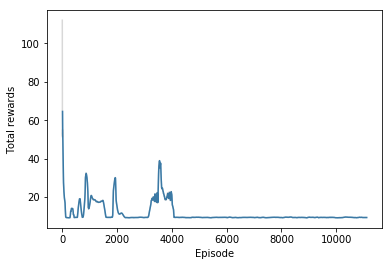

In [50]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

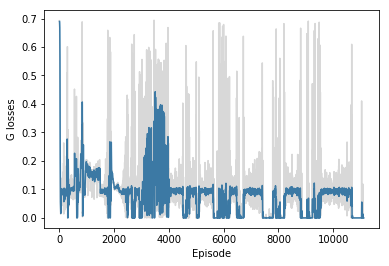

In [51]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

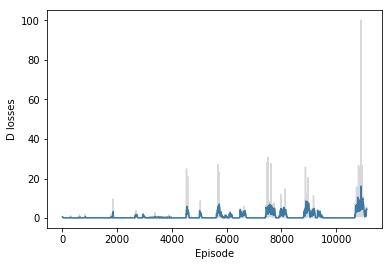

In [52]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.